In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('/Volumes/harris/volkan/sleep_profile/downsample_auto_score/sub-007_ses-01_recording-01_time-0-70.5h_sr-1hz.csv')

# Convert Timestamp column to datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Round the numbers in the sleepStage column to the nearest integer
df['sleepStage'] = df['sleepStage'].round().astype(int)

# Create a new column to track changes in sleep stage
df['sleepStageChange'] = df['sleepStage'] != df['sleepStage'].shift()

# Create a cumulative sum of changes to identify continuous instances
df['boutId'] = df['sleepStageChange'].cumsum()

# Group by boutId and sleepStage, then calculate the count of rows for each bout
bout_durations = df.groupby(['boutId', 'sleepStage']).size().reset_index(name='boutDuration')

# Map sleep stages to their corresponding names (optional)
sleep_stage_map = {1: 'Wake', 2: 'NREM', 3: 'REM'}
bout_durations['sleepStage'] = bout_durations['sleepStage'].map(sleep_stage_map)

# Determine the time period (light or dark) for each bout
def get_time_period(row):
    hour = row['Timestamp'].hour
    if 9 <= hour < 21:
        return 'Light'
    else:
        return 'Dark'

# Apply the function to the original dataframe to get the time period for each row
df['timePeriod'] = df.apply(get_time_period, axis=1)

# Group by boutId and get the time period for each bout (assuming the time period is the same for all rows in a bout)
bout_time_periods = df.groupby('boutId')['timePeriod'].unique().str[0].reset_index()

# Merge the bout durations with the time periods
bout_durations = pd.merge(bout_durations, bout_time_periods, on='boutId')

# Print the bout durations with time periods
print(bout_durations)

In [ ]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# List of CSV file paths
csv_files = glob.glob('/Volumes/harris/volkan/sleep_profile/downsample_auto_score/bout_duration/*.csv')

# Dictionary to store results
results = {}

for file in csv_files:
    # Load the CSV file
    df = pd.read_csv(file)
    
    # Convert Timestamp column to datetime format
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Round the numbers in the sleepStage column to the nearest integer
    df['sleepStage'] = df['sleepStage'].round().astype(int)
    
    # Create a new column to track changes in sleep stage
    df['sleepStageChange'] = df['sleepStage'] != df['sleepStage'].shift()
    
    # Create a cumulative sum of changes to identify continuous instances
    df['boutId'] = df['sleepStageChange'].cumsum()
    
    # Determine the time period (light or dark) for each row
    def get_time_period(row):
        hour = row['Timestamp'].hour
        if 9 <= hour < 21:
            return 'Light'
        else:
            return 'Dark'
    
    df['timePeriod'] = df.apply(get_time_period, axis=1)
    
    # Group by boutId and sleepStage, then calculate the count of rows for each bout
    bout_durations = df.groupby(['boutId', 'sleepStage']).size().reset_index(name='boutDuration')
    
    # Map sleep stages to their corresponding names (optional)
    sleep_stage_map = {1: 'Wake', 2: 'NREM', 3: 'REM'}
    bout_durations['sleepStage'] = bout_durations['sleepStage'].map(sleep_stage_map)
    
    # Determine the time period for each bout based on the majority time
    bout_time_periods = df.groupby('boutId')['timePeriod'].apply(lambda x: x.value_counts().index[0]).reset_index()
    
    # Merge the bout durations with the time periods
    bout_durations = pd.merge(bout_durations, bout_time_periods, on='boutId')
    
    # Group by timePeriod and sleepStage, then calculate the mean and standard error of boutDuration
    light_dark_avg_duration_stages = bout_durations.groupby(['timePeriod', 'sleepStage'])['boutDuration'].agg(['mean', 'sem'])
    light_dark_avg_duration_all_stage = bout_durations.groupby(['timePeriod'])['boutDuration'].agg(['mean', 'sem'])
    
    # Store results in dictionary
    filename = file.split('/')[-1]
    results[filename] = {
        'bout_durations': bout_durations,
        'light_dark_avg_duration_stages': light_dark_avg_duration_stages,
        'light_dark_avg_duration_all_stage': light_dark_avg_duration_all_stage
    }

# Print results
for filename, result in results.items():
    print(f"Results for {filename}:")
    print(result['light_dark_avg_duration_stages'])
    print(result['light_dark_avg_duration_all_stage'])
    print()

# Create lists to store light and dark average bout durations
light_avg_durations = []
dark_avg_durations = []

for filename, result in results.items():
    light_avg_duration = result['light_dark_avg_duration_all_stage'].loc['Light', 'mean']
    dark_avg_duration = result['light_dark_avg_duration_all_stage'].loc['Dark', 'mean']
    light_avg_durations.append(light_avg_duration)
    dark_avg_durations.append(dark_avg_duration)

# Run paired samples t-test
t_stat, p_val = stats.ttest_rel(light_avg_durations, dark_avg_durations)

print("t-statistic:", t_stat)
print("p-value:", p_val)

# Interpret p-value
alpha = 0.05
if p_val < alpha:
    print("Reject null hypothesis: Light and Dark average bout durations are significantly different.")
else:
    print("Fail to reject null hypothesis: Light and Dark average bout durations are not significantly different.")

# Create a figure and axis
fig, ax = plt.subplots()

# Define bar positions and width
bar_width = 0.8
bar_positions = np.arange(2)

# Create bars for Light and Dark periods
light_means = []
dark_means = []
for filename, result in results.items():
    light_mean = result['light_dark_avg_duration_all_stage'].loc['Light', 'mean']
    dark_mean = result['light_dark_avg_duration_all_stage'].loc['Dark', 'mean']
    light_means.append(light_mean)
    dark_means.append(dark_mean)

# Calculate mean and standard error for bars
light_mean = np.mean(light_means)
light_sem = stats.sem(light_means)
dark_mean = np.mean(dark_means)
dark_sem = stats.sem(dark_means)

ax.bar(bar_positions[0], light_mean, bar_width, label='Light', capsize=5)
ax.bar(bar_positions[1], dark_mean, bar_width, label='Dark', capsize=5)

# Add lines connecting individual subject means
for i in range(len(light_means)):
    ax.plot(bar_positions, [light_means[i], dark_means[i]], 'o-', linewidth=0.5, color='gray', alpha=0.5)

# Add scatter plot for individual means
ax.scatter(np.repeat(bar_positions[0], len(light_means)), light_means, alpha=0.5)
ax.scatter(np.repeat(bar_positions[1], len(dark_means)), dark_means, alpha=0.5)

# Set x-axis ticks and labels
ax.set_xticks(bar_positions)
ax.set_xticklabels(['Light', 'Dark'])

# Add legend and labels
ax.set_ylabel('Mean Bout Duration (seconds)')
ax.set_title('Bout Duration Across All Phases')

# Show plot
plt.show()

In [ ]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# List of CSV file paths
csv_files = glob.glob('/Volumes/harris/volkan/sleep_profile/downsample_auto_score/bout_duration/*.csv')

# Dictionary to store results
results = {}

for file in csv_files:
    # Load the CSV file
    df = pd.read_csv(file)
    
    # Convert Timestamp column to datetime format
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Round the numbers in the sleepStage column to the nearest integer
    df['sleepStage'] = df['sleepStage'].round().astype(int)
    
    # Create a new column to track changes in sleep stage
    df['sleepStageChange'] = df['sleepStage'] != df['sleepStage'].shift()
    
    # Create a cumulative sum of changes to identify continuous instances
    df['boutId'] = df['sleepStageChange'].cumsum()
    
    # Determine the time period (light or dark) for each row
    def get_time_period(row):
        hour = row['Timestamp'].hour
        if 9 <= hour < 21:
            return 'Light'
        else:
            return 'Dark'
    
    df['timePeriod'] = df.apply(get_time_period, axis=1)
    
    # Group by boutId and sleepStage, then calculate the count of rows for each bout
    bout_durations = df.groupby(['boutId', 'sleepStage']).size().reset_index(name='boutDuration')
    
    # Filter out bout durations less than 10 seconds
    bout_durations = bout_durations[bout_durations['boutDuration'] >= 10]
    
    # Map sleep stages to their corresponding names (optional)
    sleep_stage_map = {1: 'Wake', 2: 'NREM', 3: 'REM'}
    bout_durations['sleepStage'] = bout_durations['sleepStage'].map(sleep_stage_map)
    
    # Determine the time period for each bout based on the majority time
    bout_time_periods = df.groupby('boutId')['timePeriod'].apply(lambda x: x.value_counts().index[0]).reset_index()
    
    # Merge the bout durations with the time periods
    bout_durations = pd.merge(bout_durations, bout_time_periods, on='boutId')
    
    # Group by timePeriod and sleepStage, then calculate the mean and standard error of boutDuration
    light_dark_avg_duration_stages = bout_durations.groupby(['timePeriod', 'sleepStage'])['boutDuration'].agg(['mean', 'sem'])
    light_dark_avg_duration_all_stage = bout_durations.groupby(['timePeriod'])['boutDuration'].agg(['mean', 'sem'])
    
    # Store results in dictionary
    filename = file.split('/')[-1]
    results[filename] = {
        'bout_durations': bout_durations,
        'light_dark_avg_duration_stages': light_dark_avg_duration_stages,
        'light_dark_avg_duration_all_stage': light_dark_avg_duration_all_stage
    }

# Print results
for filename, result in results.items():
    print(f"Results for {filename}:")
    print(result['light_dark_avg_duration_stages'])
    print(result['light_dark_avg_duration_all_stage'])
    print()

# Create lists to store light and dark average bout durations
light_avg_durations = []
dark_avg_durations = []

for filename, result in results.items():
    light_avg_duration = result['light_dark_avg_duration_all_stage'].loc['Light', 'mean']
    dark_avg_duration = result['light_dark_avg_duration_all_stage'].loc['Dark', 'mean']
    light_avg_durations.append(light_avg_duration)
    dark_avg_durations.append(dark_avg_duration)

# Run paired samples t-test
t_stat, p_val = stats.ttest_rel(light_avg_durations, dark_avg_durations)

print("t-statistic:", t_stat)
print("p-value:", p_val)

# Interpret p-value
alpha = 0.05
if p_val < alpha:
    print("Reject null hypothesis: Light and Dark average bout durations are significantly different.")
else:
    print("Fail to reject null hypothesis: Light and Dark average bout durations are not significantly different.")

# Create a figure and axis
fig, ax = plt.subplots()

# Define bar positions and width
bar_width = 0.8
bar_positions = np.arange(2)

# Create bars for Light and Dark periods
light_means = []
dark_means = []
for filename, result in results.items():
    light_mean = result['light_dark_avg_duration_all_stage'].loc['Light', 'mean']
    dark_mean = result['light_dark_avg_duration_all_stage'].loc['Dark', 'mean']
    light_means.append(light_mean)
    dark_means.append(dark_mean)

# Calculate mean and standard error for bars
light_mean = np.mean(light_means)
light_sem = stats.sem(light_means)
dark_mean = np.mean(dark_means)
dark_sem = stats.sem(dark_means)

ax.bar(bar_positions[0], light_mean, bar_width, label='Light', capsize=5)
ax.bar(bar_positions[1], dark_mean, bar_width, label='Dark', capsize=5)

# Add lines connecting individual subject means
for i in range(len(light_means)):
    ax.plot(bar_positions, [light_means[i], dark_means[i]], 'o-', linewidth=0.5, color='gray', alpha=0.5)

# Add scatter plot for individual means
ax.scatter(np.repeat(bar_positions[0], len(light_means)), light_means, alpha=0.5)
ax.scatter(np.repeat(bar_positions[1], len(dark_means)), dark_means, alpha=0.5)

# Set x-axis ticks and labels
ax.set_xticks(bar_positions)
ax.set_xticklabels(['Light', 'Dark'])

# Add legend and labels
ax.set_ylabel('Mean Bout Duration (seconds)')
ax.set_title('Bout Duration Across All Phases excluding <10 second bouts')

# Show plot
plt.show()

In [ ]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# List of CSV file paths
csv_files = glob.glob('/Volumes/harris/volkan/sleep_profile/downsample_auto_score/bout_duration/*.csv')

# Dictionary to store results
results = {}

for file in csv_files:
    # Load the CSV file
    df = pd.read_csv(file)
    
    # Convert Timestamp column to datetime format
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Round the numbers in the sleepStage column to the nearest integer
    df['sleepStage'] = df['sleepStage'].round().astype(int)
    
    # Create a new column to track changes in sleep stage
    df['sleepStageChange'] = df['sleepStage'] != df['sleepStage'].shift()
    
    # Create a cumulative sum of changes to identify continuous instances
    df['boutId'] = df['sleepStageChange'].cumsum()
    
    # Determine the time period (light or dark) for each row
    def get_time_period(row):
        hour = row['Timestamp'].hour
        if 9 <= hour < 21:
            return 'Light'
        else:
            return 'Dark'
    
    df['timePeriod'] = df.apply(get_time_period, axis=1)
    
    # Group by boutId and sleepStage, then calculate the count of rows for each bout
    bout_durations = df.groupby(['boutId', 'sleepStage']).size().reset_index(name='boutDuration')
    
    # Map sleep stages to their corresponding names (optional)
    sleep_stage_map = {1: 'Wake', 2: 'NREM', 3: 'REM'}
    bout_durations['sleepStage'] = bout_durations['sleepStage'].map(sleep_stage_map)
    
    # Determine the time period for each bout based on the majority time
    bout_time_periods = df.groupby('boutId')['timePeriod'].apply(lambda x: x.value_counts().index[0]).reset_index()
    
    # Merge the bout durations with the time periods
    bout_durations = pd.merge(bout_durations, bout_time_periods, on='boutId')
    
    # Group by timePeriod and sleepStage, then calculate the mean and standard error of boutDuration
    light_dark_avg_duration_stages = bout_durations.groupby(['timePeriod', 'sleepStage'])['boutDuration'].agg(['mean', 'sem'])
    light_dark_avg_duration_all_stage = bout_durations.groupby(['timePeriod'])['boutDuration'].agg(['mean', 'sem'])
    
    # Store results in dictionary
    filename = file.split('/')[-1]
    results[filename] = {
        'bout_durations': bout_durations,
        'light_dark_avg_duration_stages': light_dark_avg_duration_stages,
        'light_dark_avg_duration_all_stage': light_dark_avg_duration_all_stage
    }

# Print results
for filename, result in results.items():
    print(f"Results for {filename}:")
    print(result['light_dark_avg_duration_stages'])
    print(result['light_dark_avg_duration_all_stage'])
    print()

# Create lists to store average bout durations for Wake, NREM, and REM
wake_avg_durations = []
nrem_avg_durations = []
rem_avg_durations = []

# Dictionary to store individual subject data
subject_data = {'Wake': [], 'NREM': [], 'REM': []}

for filename, result in results.items():
    wake_avg_duration = result['light_dark_avg_duration_stages'].loc[('Light', 'Wake'), 'mean']
    nrem_avg_duration = result['light_dark_avg_duration_stages'].loc[('Light', 'NREM'), 'mean']
    rem_avg_duration = result['light_dark_avg_duration_stages'].loc[('Light', 'REM'), 'mean']
    
    wake_avg_durations.append(wake_avg_duration)
    nrem_avg_durations.append(nrem_avg_duration)
    rem_avg_durations.append(rem_avg_duration)
    
    # Store individual subject data
    subject_data['Wake'].append(result['light_dark_avg_duration_stages'].loc[('Light', 'Wake'), 'mean'])
    subject_data['NREM'].append(result['light_dark_avg_duration_stages'].loc[('Light', 'NREM'), 'mean'])
    subject_data['REM'].append(result['light_dark_avg_duration_stages'].loc[('Light', 'REM'), 'mean'])

# Calculate mean and standard error for bars
wake_mean = np.mean(wake_avg_durations)
wake_sem = np.std(wake_avg_durations) / np.sqrt(len(wake_avg_durations))
nrem_mean = np.mean(nrem_avg_durations)
nrem_sem = np.std(nrem_avg_durations) / np.sqrt(len(nrem_avg_durations))
rem_mean = np.mean(rem_avg_durations)
rem_sem = np.std(rem_avg_durations) / np.sqrt(len(rem_avg_durations))

# Create bar plot
bar_width = 0.8
bar_positions = np.arange(3)
plt.bar(bar_positions[0], wake_mean, bar_width, capsize=5, color='#ff9999', label='Wake')
plt.bar(bar_positions[1], nrem_mean, bar_width, capsize=5, color='#66b3ff', label='NREM')
plt.bar(bar_positions[2], rem_mean, bar_width, capsize=5, color='#99ff99', label='REM')

# Add scatter plot for individual subjects
plt.scatter(np.repeat(bar_positions[0], len(subject_data['Wake'])), subject_data['Wake'], alpha=0.5)
plt.scatter(np.repeat(bar_positions[1], len(subject_data['NREM'])), subject_data['NREM'], alpha=0.5)
plt.scatter(np.repeat(bar_positions[2], len(subject_data['REM'])), subject_data['REM'], alpha=0.5)

# Add lines connecting individual subject means
for i in range(len(subject_data['Wake'])):
    wake_x = 0
    nrem_x = 1
    rem_x = 2
    wake_y = subject_data['Wake'][i]
    nrem_y = subject_data['NREM'][i]
    rem_y = subject_data['REM'][i]
    
    plt.plot([wake_x, nrem_x], [wake_y, nrem_y], 'o-', linewidth=0.5, color='gray', alpha=0.5)
    plt.plot([nrem_x, rem_x], [nrem_y, rem_y], 'o-', linewidth=0.5, color='gray', alpha=0.5)

# Set x-axis ticks and labels
plt.xticks(bar_positions, ['Wake', 'NREM', 'REM'])
plt.ylabel('Mean Bout Duration (seconds)')
plt.title('Bout Duration by Sleep Stage')

# Show plot
plt.show()

Results for sub-011_ses-01_recording-01_time-0-72h_sr-1hz.csv:
                             mean        sem
timePeriod sleepStage                       
Dark       NREM         92.184783   4.054887
           REM          63.101124   4.694607
           Wake        325.904762  47.785474
Light      NREM        127.207661   5.132754
           REM          60.310559   3.508699
           Wake        226.229787  40.387723
                  mean        sem
timePeriod                       
Dark        162.483146  15.700429
Light       141.220852  11.179577

Results for sub-016_ses-02_recording-01_time-0-91h_sr-1hz.csv:
                             mean        sem
timePeriod sleepStage                       
Dark       NREM         97.228535   3.037708
           REM          55.502326   3.219304
           Wake        187.724638  27.794560
Light      NREM        105.191358   3.156178
           REM          59.524510   3.252364
           Wake        131.439732  17.781958
                 

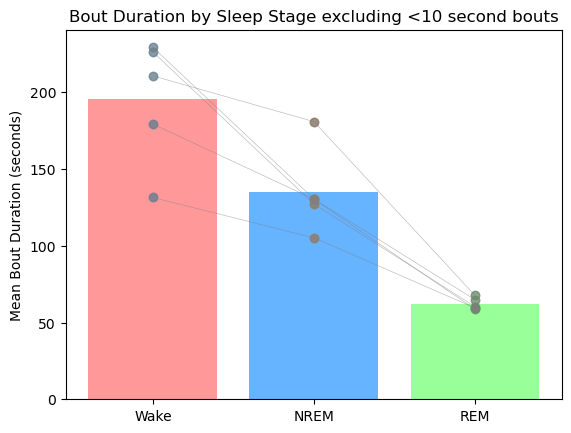

In [13]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# List of CSV file paths
csv_files = glob.glob('/Volumes/harris/volkan/sleep_profile/downsample_auto_score/bout_duration/*.csv')

# Dictionary to store results
results = {}

for file in csv_files:
    # Load the CSV file
    df = pd.read_csv(file)
    
    # Convert Timestamp column to datetime format
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Round the numbers in the sleepStage column to the nearest integer
    df['sleepStage'] = df['sleepStage'].round().astype(int)
    
    # Create a new column to track changes in sleep stage
    df['sleepStageChange'] = df['sleepStage'] != df['sleepStage'].shift()
    
    # Create a cumulative sum of changes to identify continuous instances
    df['boutId'] = df['sleepStageChange'].cumsum()
    
    # Determine the time period (light or dark) for each row
    def get_time_period(row):
        hour = row['Timestamp'].hour
        if 9 <= hour < 21:
            return 'Light'
        else:
            return 'Dark'
    
    df['timePeriod'] = df.apply(get_time_period, axis=1)
    
    # Group by boutId and sleepStage, then calculate the count of rows for each bout
    bout_durations = df.groupby(['boutId', 'sleepStage']).size().reset_index(name='boutDuration')
    
    # Filter out bout durations less than 10 seconds
    bout_durations = bout_durations[bout_durations['boutDuration'] >= 10]
    
    # Map sleep stages to their corresponding names (optional)
    sleep_stage_map = {1: 'Wake', 2: 'NREM', 3: 'REM'}
    bout_durations['sleepStage'] = bout_durations['sleepStage'].map(sleep_stage_map)
    
    # Determine the time period for each bout based on the majority time
    bout_time_periods = df.groupby('boutId')['timePeriod'].apply(lambda x: x.value_counts().index[0]).reset_index()
    
    # Merge the bout durations with the time periods
    bout_durations = pd.merge(bout_durations, bout_time_periods, on='boutId')
    
    # Group by timePeriod and sleepStage, then calculate the mean and standard error of boutDuration
    light_dark_avg_duration_stages = bout_durations.groupby(['timePeriod', 'sleepStage'])['boutDuration'].agg(['mean', 'sem'])
    light_dark_avg_duration_all_stage = bout_durations.groupby(['timePeriod'])['boutDuration'].agg(['mean', 'sem'])
    
    # Store results in dictionary
    filename = file.split('/')[-1]
    results[filename] = {
        'bout_durations': bout_durations,
        'light_dark_avg_duration_stages': light_dark_avg_duration_stages,
        'light_dark_avg_duration_all_stage': light_dark_avg_duration_all_stage
    }

# Print results
for filename, result in results.items():
    print(f"Results for {filename}:")
    print(result['light_dark_avg_duration_stages'])
    print(result['light_dark_avg_duration_all_stage'])
    print()

# Create lists to store average bout durations for Wake, NREM, and REM
wake_avg_durations = []
nrem_avg_durations = []
rem_avg_durations = []

# Dictionary to store individual subject data
subject_data = {'Wake': [], 'NREM': [], 'REM': []}

for filename, result in results.items():
    wake_avg_duration = result['light_dark_avg_duration_stages'].loc[('Light', 'Wake'), 'mean']
    nrem_avg_duration = result['light_dark_avg_duration_stages'].loc[('Light', 'NREM'), 'mean']
    rem_avg_duration = result['light_dark_avg_duration_stages'].loc[('Light', 'REM'), 'mean']
    
    wake_avg_durations.append(wake_avg_duration)
    nrem_avg_durations.append(nrem_avg_duration)
    rem_avg_durations.append(rem_avg_duration)
    
    # Store individual subject data
    subject_data['Wake'].append(result['light_dark_avg_duration_stages'].loc[('Light', 'Wake'), 'mean'])
    subject_data['NREM'].append(result['light_dark_avg_duration_stages'].loc[('Light', 'NREM'), 'mean'])
    subject_data['REM'].append(result['light_dark_avg_duration_stages'].loc[('Light', 'REM'), 'mean'])

# Calculate mean and standard error for bars
wake_mean = np.mean(wake_avg_durations)
wake_sem = np.std(wake_avg_durations) / np.sqrt(len(wake_avg_durations))
nrem_mean = np.mean(nrem_avg_durations)
nrem_sem = np.std(nrem_avg_durations) / np.sqrt(len(nrem_avg_durations))
rem_mean = np.mean(rem_avg_durations)
rem_sem = np.std(rem_avg_durations) / np.sqrt(len(rem_avg_durations))

# Create bar plot
bar_width = 0.8
bar_positions = np.arange(3)
plt.bar(bar_positions[0], wake_mean, bar_width, capsize=5, color='#ff9999', label='Wake')
plt.bar(bar_positions[1], nrem_mean, bar_width, capsize=5, color='#66b3ff', label='NREM')
plt.bar(bar_positions[2], rem_mean, bar_width, capsize=5, color='#99ff99', label='REM')

# Add scatter plot for individual subjects
plt.scatter(np.repeat(bar_positions[0], len(subject_data['Wake'])), subject_data['Wake'], alpha=0.5)
plt.scatter(np.repeat(bar_positions[1], len(subject_data['NREM'])), subject_data['NREM'], alpha=0.5)
plt.scatter(np.repeat(bar_positions[2], len(subject_data['REM'])), subject_data['REM'], alpha=0.5)

# Add lines connecting individual subject means
for i in range(len(subject_data['Wake'])):
    wake_x = 0
    nrem_x = 1
    rem_x = 2
    wake_y = subject_data['Wake'][i]
    nrem_y = subject_data['NREM'][i]
    rem_y = subject_data['REM'][i]
    
    plt.plot([wake_x, nrem_x], [wake_y, nrem_y], 'o-', linewidth=0.5, color='gray', alpha=0.5)
    plt.plot([nrem_x, rem_x], [nrem_y, rem_y], 'o-', linewidth=0.5, color='gray', alpha=0.5)

# Set x-axis ticks and labels
plt.xticks(bar_positions, ['Wake', 'NREM', 'REM'])
plt.ylabel('Mean Bout Duration (seconds)')
plt.title('Bout Duration by Sleep Stage excluding <10 second bouts')

# Show plot
plt.show()

Results for sub-011_ses-01_recording-01_time-0-72h_sr-1hz.csv:
                             mean        sem
timePeriod sleepStage                       
Dark       NREM         87.767010   3.941040
           REM          56.000000   4.491801
           Wake        177.952991  26.749596
Light      NREM        118.362617   4.950244
           REM          54.419890   3.359694
           Wake        114.148847  20.510649
                 mean        sem
timePeriod                      
Dark        124.70237  12.096513
Light       106.97653   8.530416

Results for sub-016_ses-02_recording-01_time-0-91h_sr-1hz.csv:
                             mean        sem
timePeriod sleepStage                       
Dark       NREM         92.811071   2.976455
           REM          51.956897   3.096213
           Wake        103.254215  15.272400
Light      NREM        102.189222   3.118336
           REM          55.727273   3.151566
           Wake         75.791250  10.197903
                 mean

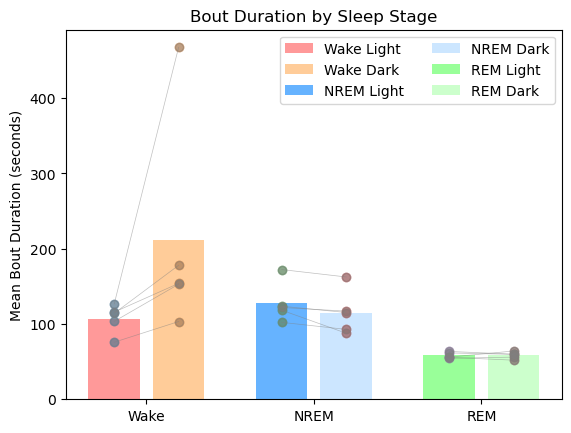

In [14]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# List of CSV file paths
csv_files = glob.glob('/Volumes/harris/volkan/sleep_profile/downsample_auto_score/bout_duration/*.csv')

# Dictionary to store results
results = {}

for file in csv_files:
    # Load the CSV file
    df = pd.read_csv(file)
    
    # Convert Timestamp column to datetime format
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Round the numbers in the sleepStage column to the nearest integer
    df['sleepStage'] = df['sleepStage'].round().astype(int)
    
    # Create a new column to track changes in sleep stage
    df['sleepStageChange'] = df['sleepStage'] != df['sleepStage'].shift()
    
    # Create a cumulative sum of changes to identify continuous instances
    df['boutId'] = df['sleepStageChange'].cumsum()
    
    # Determine the time period (light or dark) for each row
    def get_time_period(row):
        hour = row['Timestamp'].hour
        if 9 <= hour < 21:
            return 'Light'
        else:
            return 'Dark'
    
    df['timePeriod'] = df.apply(get_time_period, axis=1)
    
    # Group by boutId and sleepStage, then calculate the count of rows for each bout
    bout_durations = df.groupby(['boutId', 'sleepStage']).size().reset_index(name='boutDuration')
    
    # Map sleep stages to their corresponding names (optional)
    sleep_stage_map = {1: 'Wake', 2: 'NREM', 3: 'REM'}
    bout_durations['sleepStage'] = bout_durations['sleepStage'].map(sleep_stage_map)
    
    # Determine the time period for each bout based on the majority time
    bout_time_periods = df.groupby('boutId')['timePeriod'].apply(lambda x: x.value_counts().index[0]).reset_index()
    
    # Merge the bout durations with the time periods
    bout_durations = pd.merge(bout_durations, bout_time_periods, on='boutId')
    
    # Group by timePeriod and sleepStage, then calculate the mean and standard error of boutDuration
    light_dark_avg_duration_stages = bout_durations.groupby(['timePeriod', 'sleepStage'])['boutDuration'].agg(['mean', 'sem'])
    light_dark_avg_duration_all_stage = bout_durations.groupby(['timePeriod'])['boutDuration'].agg(['mean', 'sem'])
    
    # Store results in dictionary
    filename = file.split('/')[-1]
    results[filename] = {
        'bout_durations': bout_durations,
        'light_dark_avg_duration_stages': light_dark_avg_duration_stages,
        'light_dark_avg_duration_all_stage': light_dark_avg_duration_all_stage
    }

# Print results
for filename, result in results.items():
    print(f"Results for {filename}:")
    print(result['light_dark_avg_duration_stages'])
    print(result['light_dark_avg_duration_all_stage'])
    print()

# Create lists to store average bout durations for Wake, NREM, and REM
wake_avg_durations = []
nrem_avg_durations = []
rem_avg_durations = []

# Dictionary to store individual subject data
subject_data = {'Wake': [], 'NREM': [], 'REM': []}

for filename, result in results.items():
    wake_avg_duration = result['light_dark_avg_duration_stages'].loc[('Light', 'Wake'), 'mean']
    nrem_avg_duration = result['light_dark_avg_duration_stages'].loc[('Light', 'NREM'), 'mean']
    rem_avg_duration = result['light_dark_avg_duration_stages'].loc[('Light', 'REM'), 'mean']
    
    wake_avg_durations.append(wake_avg_duration)
    nrem_avg_durations.append(nrem_avg_duration)
    rem_avg_durations.append(rem_avg_duration)
    
    # Store individual subject data
    subject_data['Wake'].append(result['light_dark_avg_duration_stages'].loc[('Light', 'Wake'), 'mean'])
    subject_data['NREM'].append(result['light_dark_avg_duration_stages'].loc[('Light', 'NREM'), 'mean'])
    subject_data['REM'].append(result['light_dark_avg_duration_stages'].loc[('Light', 'REM'), 'mean'])

# Calculate mean and standard error for bars
wake_light_mean = np.mean([result['light_dark_avg_duration_stages'].loc[('Light', 'Wake'), 'mean'] for result in results.values()])
wake_light_sem = stats.sem([result['light_dark_avg_duration_stages'].loc[('Light', 'Wake'), 'mean'] for result in results.values()])
wake_dark_mean = np.mean([result['light_dark_avg_duration_stages'].loc[('Dark', 'Wake'), 'mean'] for result in results.values()])
wake_dark_sem = stats.sem([result['light_dark_avg_duration_stages'].loc[('Dark', 'Wake'), 'mean'] for result in results.values()])

nrem_light_mean = np.mean([result['light_dark_avg_duration_stages'].loc[('Light', 'NREM'), 'mean'] for result in results.values()])
nrem_light_sem = stats.sem([result['light_dark_avg_duration_stages'].loc[('Light', 'NREM'), 'mean'] for result in results.values()])
nrem_dark_mean = np.mean([result['light_dark_avg_duration_stages'].loc[('Dark', 'NREM'), 'mean'] for result in results.values()])
nrem_dark_sem = stats.sem([result['light_dark_avg_duration_stages'].loc[('Dark', 'NREM'), 'mean'] for result in results.values()])

rem_light_mean = np.mean([result['light_dark_avg_duration_stages'].loc[('Light', 'REM'), 'mean'] for result in results.values()])
rem_light_sem = stats.sem([result['light_dark_avg_duration_stages'].loc[('Light', 'REM'), 'mean'] for result in results.values()])
rem_dark_mean = np.mean([result['light_dark_avg_duration_stages'].loc[('Dark', 'REM'), 'mean'] for result in results.values()])
rem_dark_sem = stats.sem([result['light_dark_avg_duration_stages'].loc[('Dark', 'REM'), 'mean'] for result in results.values()])

# Create bar plot
bar_width = 0.2
bar_spacing = 0.25  # Reduced spacing

wake_light_pos = 0
wake_dark_pos = wake_light_pos + bar_spacing
nrem_light_pos = wake_dark_pos + bar_width + 0.2  # Increased spacing between groups
nrem_dark_pos = nrem_light_pos + bar_spacing
rem_light_pos = nrem_dark_pos + bar_width + 0.2  # Increased spacing between groups
rem_dark_pos = rem_light_pos + bar_spacing

plt.bar(wake_light_pos, wake_light_mean, bar_width, capsize=5, color='#ff9999', label='Wake Light')
plt.bar(wake_dark_pos, wake_dark_mean, bar_width, capsize=5, color='#ffcc99', label='Wake Dark')
plt.bar(nrem_light_pos, nrem_light_mean, bar_width,capsize=5, color='#66b3ff', label='NREM Light')
plt.bar(nrem_dark_pos, nrem_dark_mean, bar_width, capsize=5, color='#cce6ff', label='NREM Dark')
plt.bar(rem_light_pos, rem_light_mean, bar_width, capsize=5, color='#99ff99', label='REM Light')
plt.bar(rem_dark_pos, rem_dark_mean, bar_width, capsize=5, color='#ccffcc', label='REM Dark')

# Add scatter plot for individual subjects
wake_light_data = [result['light_dark_avg_duration_stages'].loc[('Light', 'Wake'), 'mean'] for result in results.values()]
wake_dark_data = [result['light_dark_avg_duration_stages'].loc[('Dark', 'Wake'), 'mean'] for result in results.values()]
nrem_light_data = [result['light_dark_avg_duration_stages'].loc[('Light', 'NREM'), 'mean'] for result in results.values()]
nrem_dark_data = [result['light_dark_avg_duration_stages'].loc[('Dark', 'NREM'), 'mean'] for result in results.values()]
rem_light_data = [result['light_dark_avg_duration_stages'].loc[('Light', 'REM'), 'mean'] for result in results.values()]
rem_dark_data = [result['light_dark_avg_duration_stages'].loc[('Dark', 'REM'), 'mean'] for result in results.values()]

plt.scatter(np.repeat(wake_light_pos, len(wake_light_data)), wake_light_data, alpha=0.5)
plt.scatter(np.repeat(wake_dark_pos, len(wake_dark_data)), wake_dark_data, alpha=0.5)
plt.scatter(np.repeat(nrem_light_pos, len(nrem_light_data)), nrem_light_data, alpha=0.5)
plt.scatter(np.repeat(nrem_dark_pos, len(nrem_dark_data)), nrem_dark_data, alpha=0.5)
plt.scatter(np.repeat(rem_light_pos, len(rem_light_data)), rem_light_data, alpha=0.5)
plt.scatter(np.repeat(rem_dark_pos, len(rem_dark_data)), rem_dark_data, alpha=0.5)

# Add lines connecting individual subject means
for i in range(len(wake_light_data)):
    wake_light_x = wake_light_pos
    wake_dark_x = wake_dark_pos
    nrem_light_x = nrem_light_pos
    nrem_dark_x = nrem_dark_pos
    rem_light_x = rem_light_pos
    rem_dark_x = rem_dark_pos
    
    wake_light_y = wake_light_data[i]
    wake_dark_y = wake_dark_data[i]
    nrem_light_y = nrem_light_data[i]
    nrem_dark_y = nrem_dark_data[i]
    rem_light_y = rem_light_data[i]
    rem_dark_y = rem_dark_data[i]
    
    plt.plot([wake_light_x, wake_dark_x], [wake_light_y, wake_dark_y], 'o-', linewidth=0.5, color='gray', alpha=0.5)
    plt.plot([nrem_light_x, nrem_dark_x], [nrem_light_y, nrem_dark_y], 'o-', linewidth=0.5, color='gray', alpha=0.5)
    plt.plot([rem_light_x, rem_dark_x], [rem_light_y, rem_dark_y], 'o-', linewidth=0.5, color='gray', alpha=0.5)

# Set x-axis ticks and labels
plt.xticks([(wake_light_pos + wake_dark_pos) / 2, (nrem_light_pos + nrem_dark_pos) / 2, (rem_light_pos + rem_dark_pos) / 2], 
           ['Wake', 'NREM', 'REM'])
plt.ylabel('Mean Bout Duration (seconds)')
plt.title('Bout Duration by Sleep Stage')

# Add legend
plt.legend(ncol=2)

# Show plot
plt.show()


2-Way ANOVA Results:
                    sum_sq    df         F    PR(>F)
C(Condition)  79306.955835   5.0  4.090265  0.007923
Residual      93068.153446  24.0       NaN       NaN

Tukey's Post-Hoc Test Results:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
  group1     group2    meandiff p-adj    lower    upper   reject
----------------------------------------------------------------
 NREM Dark NREM Light   12.6166 0.9995 -109.1575 134.3906  False
 NREM Dark   REM Dark  -56.7272 0.7031 -178.5013  65.0468  False
 NREM Dark  REM Light  -56.8214 0.7017 -178.5955  64.9526  False
 NREM Dark  Wake Dark   96.0238 0.1831  -25.7503 217.7978  False
 NREM Dark Wake Light   -7.8937 0.9999 -129.6677 113.8804  False
NREM Light   REM Dark  -69.3438 0.5079 -191.1178  52.4303  False
NREM Light  REM Light   -69.438 0.5064 -191.2121   52.336  False
NREM Light  Wake Dark   83.4072 0.3119  -38.3668 205.1813  False
NREM Light Wake Light  -20.5102 0.9948 -142.2843 101.2638  False
  REM Da

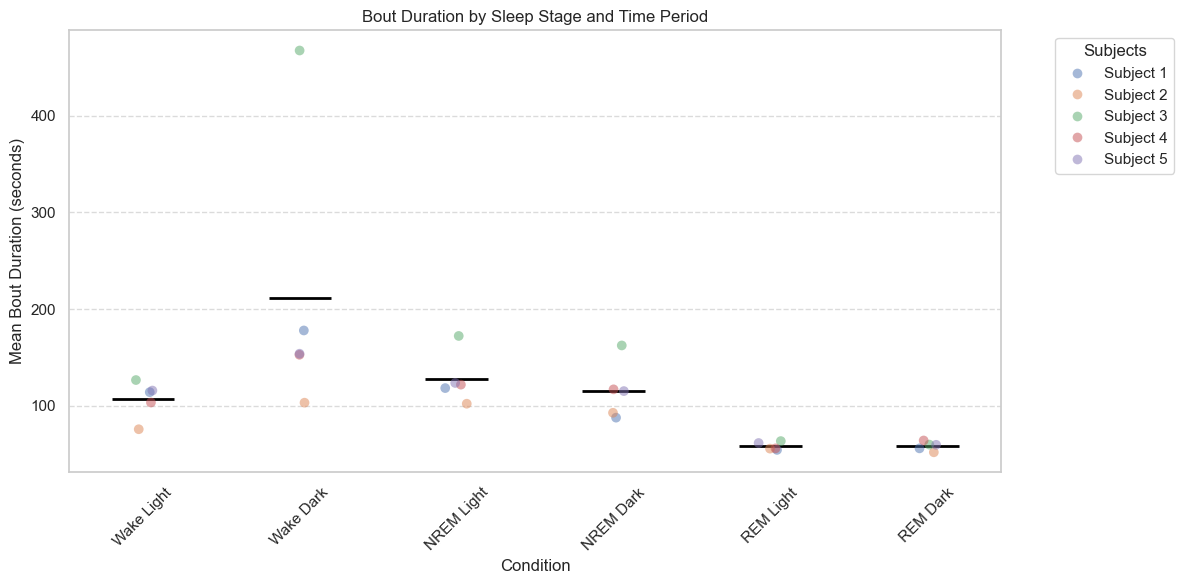

In [34]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# List of CSV file paths
csv_files = glob.glob('/Volumes/harris/volkan/sleep_profile/downsample_auto_score/bout_duration/*.csv')

# Dictionary to store results
results = {}

for file in csv_files:
    # Load the CSV file
    df = pd.read_csv(file)
    
    # Convert Timestamp column to datetime format
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Round the numbers in the sleepStage column to the nearest integer
    df['sleepStage'] = df['sleepStage'].round().astype(int)
    
    # Create a new column to track changes in sleep stage
    df['sleepStageChange'] = df['sleepStage'] != df['sleepStage'].shift()
    
    # Create a cumulative sum of changes to identify continuous instances
    df['boutId'] = df['sleepStageChange'].cumsum()
    
    # Determine the time period (light or dark) for each row
    def get_time_period(row):
        hour = row['Timestamp'].hour
        if 9 <= hour < 21:
            return 'Light'
        else:
            return 'Dark'
    
    df['timePeriod'] = df.apply(get_time_period, axis=1)
    
    # Group by boutId and sleepStage, then calculate the count of rows for each bout
    bout_durations = df.groupby(['boutId', 'sleepStage']).size().reset_index(name='boutDuration')
    
    # Map sleep stages to their corresponding names
    sleep_stage_map = {1: 'Wake', 2: 'NREM', 3: 'REM'}
    bout_durations['sleepStage'] = bout_durations['sleepStage'].map(sleep_stage_map)
    
    # Determine the time period for each bout based on the majority time
    bout_time_periods = df.groupby('boutId')['timePeriod'].apply(lambda x: x.value_counts().index[0]).reset_index()
    
    # Merge the bout durations with the time periods
    bout_durations = pd.merge(bout_durations, bout_time_periods, on='boutId')
    
    # Group by timePeriod and sleepStage, then calculate the mean bout duration
    light_dark_avg_duration_stages = bout_durations.groupby(['timePeriod', 'sleepStage'])['boutDuration'].mean()
    
    # Store results in dictionary
    filename = file.split('/')[-1]
    results[filename] = {
        'bout_durations': bout_durations,
        'light_dark_avg_duration_stages': light_dark_avg_duration_stages,
    }

# Prepare data for plotting
conditions = ['Wake Light', 'Wake Dark', 'NREM Light', 'NREM Dark', 'REM Light', 'REM Dark']
stripplot_data = {cond: [] for cond in conditions}
subject_labels = []  # To store subject labels for hue

# For each condition, collect individual subject means (i.e., for each file)
for time_period, sleep_stage in [('Light', 'Wake'), ('Dark', 'Wake'), 
                                 ('Light', 'NREM'), ('Dark', 'NREM'), 
                                 ('Light', 'REM'), ('Dark', 'REM')]:
    condition = f'{sleep_stage} {time_period}'

    # Collect the individual means for the condition across all files
    for i, (filename, result) in enumerate(results.items()):
        try:
            mean = result['light_dark_avg_duration_stages'].loc[(time_period, sleep_stage)]
            stripplot_data[condition].append(mean)
            subject_labels.append(f'Subject {i+1}')  # Assign a label for each subject
        except KeyError:
            stripplot_data[condition].append(np.nan)
            subject_labels.append(f'Subject {i+1}')

# Convert subject labels and data to a DataFrame for seaborn to handle the hue
plot_data = pd.DataFrame({
    'Condition': [cond for cond in conditions for _ in range(len(csv_files))],
    'MeanBoutDuration': [item for sublist in stripplot_data.values() for item in sublist],
    'Subject': subject_labels
})

# Prepare for ANOVA
anova_data = plot_data[['Condition', 'MeanBoutDuration']]

# Run the 2-way ANOVA
model = ols('MeanBoutDuration ~ C(Condition)', data=anova_data).fit()
anova_result = anova_lm(model, typ=2)

# Print the ANOVA result
print("2-Way ANOVA Results:")
print(anova_result)

# Tukey's HSD Post-hoc test
tukey_result = pairwise_tukeyhsd(endog=anova_data['MeanBoutDuration'], 
                                 groups=anova_data['Condition'], 
                                 alpha=0.05)

# Print Tukey's HSD results
print("\nTukey's Post-Hoc Test Results:")
print(tukey_result)

# Plot
plt.figure(figsize=(12, 6))

# Create stripplot with 'hue' for different subjects
sns.stripplot(x='Condition', y='MeanBoutDuration', data=plot_data, jitter=0.08, hue='Subject', alpha=0.5, size=7)

# Plot mean as a horizontal line for each condition
for i, cond in enumerate(conditions):
    condition_data = plot_data[plot_data['Condition'] == cond]
    condition_mean = condition_data['MeanBoutDuration'].mean()
    plt.hlines(condition_mean, i - 0.2, i + 0.2, color='black', linestyle='-', linewidth=2)

# Customize plot
plt.xticks(rotation=45)
plt.ylabel('Mean Bout Duration (seconds)')
plt.title('Bout Duration by Sleep Stage and Time Period')

# Customize legend to show subjects
plt.legend(title='Subjects', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


2-Way ANOVA Results:
                    sum_sq    df          F    PR(>F)
C(Condition)  1.118017e+06   5.0  10.338616  0.000022
Residual      5.190717e+05  24.0        NaN       NaN

Tukey's Post-Hoc Test Results:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
  group1     group2    meandiff p-adj    lower    upper   reject
----------------------------------------------------------------
 NREM Dark NREM Light   13.2985    1.0 -274.2876 300.8845  False
 NREM Dark   REM Dark  -57.8709 0.9882  -345.457 229.7151  False
 NREM Dark  REM Light  -59.1671  0.987 -346.7532  228.419  False
 NREM Dark  Wake Dark  479.3502 0.0004  191.7641 766.9363   True
 NREM Dark Wake Light  209.3617 0.2524  -78.2244 496.9477  False
NREM Light   REM Dark  -71.1694 0.9708 -358.7555 216.4167  False
NREM Light  REM Light  -72.4655 0.9685 -360.0516 215.1205  False
NREM Light  Wake Dark  466.0517 0.0005  178.4657 753.6378   True
NREM Light Wake Light  196.0632 0.3166  -91.5229 483.6493  False
  REM

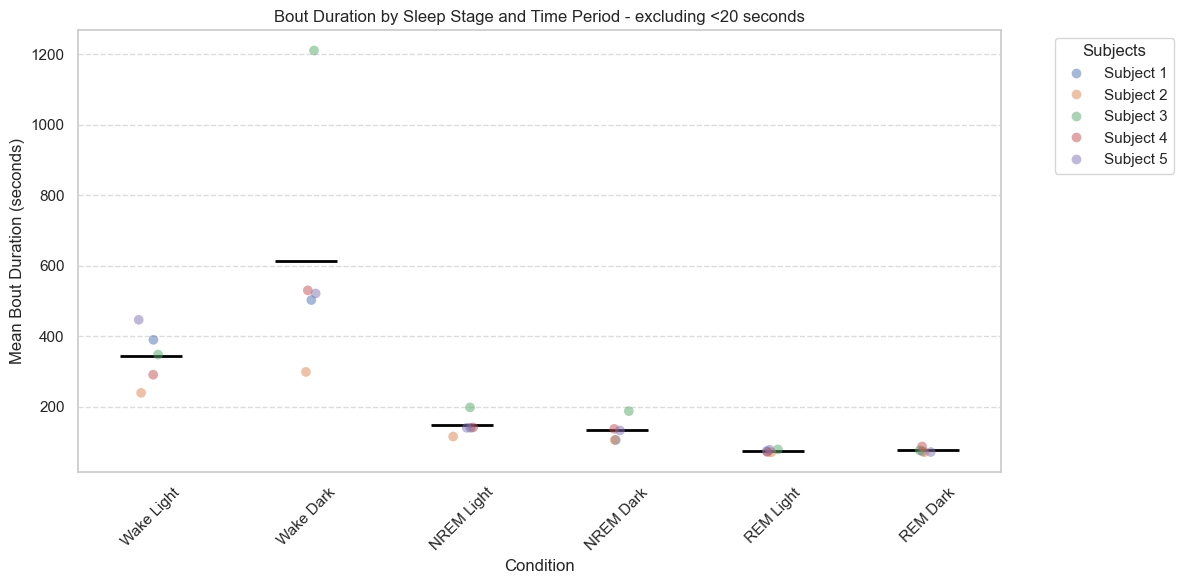

In [36]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# List of CSV file paths
csv_files = glob.glob('/Volumes/harris/volkan/sleep_profile/downsample_auto_score/bout_duration/*.csv')

# Dictionary to store results
results = {}

for file in csv_files:
    # Load the CSV file
    df = pd.read_csv(file)
    
    # Convert Timestamp column to datetime format
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Round the numbers in the sleepStage column to the nearest integer
    df['sleepStage'] = df['sleepStage'].round().astype(int)
    
    # Create a new column to track changes in sleep stage
    df['sleepStageChange'] = df['sleepStage'] != df['sleepStage'].shift()
    
    # Create a cumulative sum of changes to identify continuous instances
    df['boutId'] = df['sleepStageChange'].cumsum()
    
    # Determine the time period (light or dark) for each row
    def get_time_period(row):
        hour = row['Timestamp'].hour
        if 9 <= hour < 21:
            return 'Light'
        else:
            return 'Dark'
    
    df['timePeriod'] = df.apply(get_time_period, axis=1)
    
    # Group by boutId and sleepStage, then calculate the count of rows for each bout
    bout_durations = df.groupby(['boutId', 'sleepStage']).size().reset_index(name='boutDuration')

    # Filter out bout durations less than 20 seconds
    bout_durations = bout_durations[bout_durations['boutDuration'] >= 20]
    
    # Map sleep stages to their corresponding names
    sleep_stage_map = {1: 'Wake', 2: 'NREM', 3: 'REM'}
    bout_durations['sleepStage'] = bout_durations['sleepStage'].map(sleep_stage_map)
    
    # Determine the time period for each bout based on the majority time
    bout_time_periods = df.groupby('boutId')['timePeriod'].apply(lambda x: x.value_counts().index[0]).reset_index()
    
    # Merge the bout durations with the time periods
    bout_durations = pd.merge(bout_durations, bout_time_periods, on='boutId')
    
    # Group by timePeriod and sleepStage, then calculate the mean bout duration
    light_dark_avg_duration_stages = bout_durations.groupby(['timePeriod', 'sleepStage'])['boutDuration'].mean()
    
    # Store results in dictionary
    filename = file.split('/')[-1]
    results[filename] = {
        'bout_durations': bout_durations,
        'light_dark_avg_duration_stages': light_dark_avg_duration_stages,
    }

# Prepare data for plotting
conditions = ['Wake Light', 'Wake Dark', 'NREM Light', 'NREM Dark', 'REM Light', 'REM Dark']
stripplot_data = {cond: [] for cond in conditions}
subject_labels = []  # To store subject labels for hue

# For each condition, collect individual subject means (i.e., for each file)
for time_period, sleep_stage in [('Light', 'Wake'), ('Dark', 'Wake'), 
                                 ('Light', 'NREM'), ('Dark', 'NREM'), 
                                 ('Light', 'REM'), ('Dark', 'REM')]:
    condition = f'{sleep_stage} {time_period}'

    # Collect the individual means for the condition across all files
    for i, (filename, result) in enumerate(results.items()):
        try:
            mean = result['light_dark_avg_duration_stages'].loc[(time_period, sleep_stage)]
            stripplot_data[condition].append(mean)
            subject_labels.append(f'Subject {i+1}')  # Assign a label for each subject
        except KeyError:
            stripplot_data[condition].append(np.nan)
            subject_labels.append(f'Subject {i+1}')

# Convert subject labels and data to a DataFrame for seaborn to handle the hue
plot_data = pd.DataFrame({
    'Condition': [cond for cond in conditions for _ in range(len(csv_files))],
    'MeanBoutDuration': [item for sublist in stripplot_data.values() for item in sublist],
    'Subject': subject_labels
})

# Prepare for ANOVA
anova_data = plot_data[['Condition', 'MeanBoutDuration']]

# Run the 2-way ANOVA
model = ols('MeanBoutDuration ~ C(Condition)', data=anova_data).fit()
anova_result = anova_lm(model, typ=2)

# Print the ANOVA result
print("2-Way ANOVA Results:")
print(anova_result)

# Tukey's HSD Post-hoc test
tukey_result = pairwise_tukeyhsd(endog=anova_data['MeanBoutDuration'], 
                                 groups=anova_data['Condition'], 
                                 alpha=0.05)

# Print Tukey's HSD results
print("\nTukey's Post-Hoc Test Results:")
print(tukey_result)

# Plot
plt.figure(figsize=(12, 6))

# Create stripplot with 'hue' for different subjects
sns.stripplot(x='Condition', y='MeanBoutDuration', data=plot_data, jitter=0.08, hue='Subject', alpha=0.5, size=7)

# Plot mean as a horizontal line for each condition
for i, cond in enumerate(conditions):
    condition_data = plot_data[plot_data['Condition'] == cond]
    condition_mean = condition_data['MeanBoutDuration'].mean()
    plt.hlines(condition_mean, i - 0.2, i + 0.2, color='black', linestyle='-', linewidth=2)

# Customize plot
plt.xticks(rotation=45)
plt.ylabel('Mean Bout Duration (seconds)')
plt.title('Bout Duration by Sleep Stage and Time Period - excluding <20 seconds')

# Customize legend to show subjects
plt.legend(title='Subjects', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Kruskal-Wallis Test Results:
Test statistic: 21.774193548387117
P-value: 0.0005779550784272325

Post-hoc Pairwise Comparison using Dunn's Test:
            NREM Dark  NREM Light  REM Dark  REM Light  Wake Dark  Wake Light
NREM Dark    1.000000    1.000000  0.426576   0.322618   1.000000    1.000000
NREM Light   1.000000    1.000000  0.068146   0.048361   1.000000    1.000000
REM Dark     0.426576    0.068146  1.000000   1.000000   0.008458    0.558192
REM Light    0.322618    0.048361  1.000000   1.000000   0.005644    0.426576
Wake Dark    1.000000    1.000000  0.008458   0.005644   1.000000    1.000000
Wake Light   1.000000    1.000000  0.558192   0.426576   1.000000    1.000000


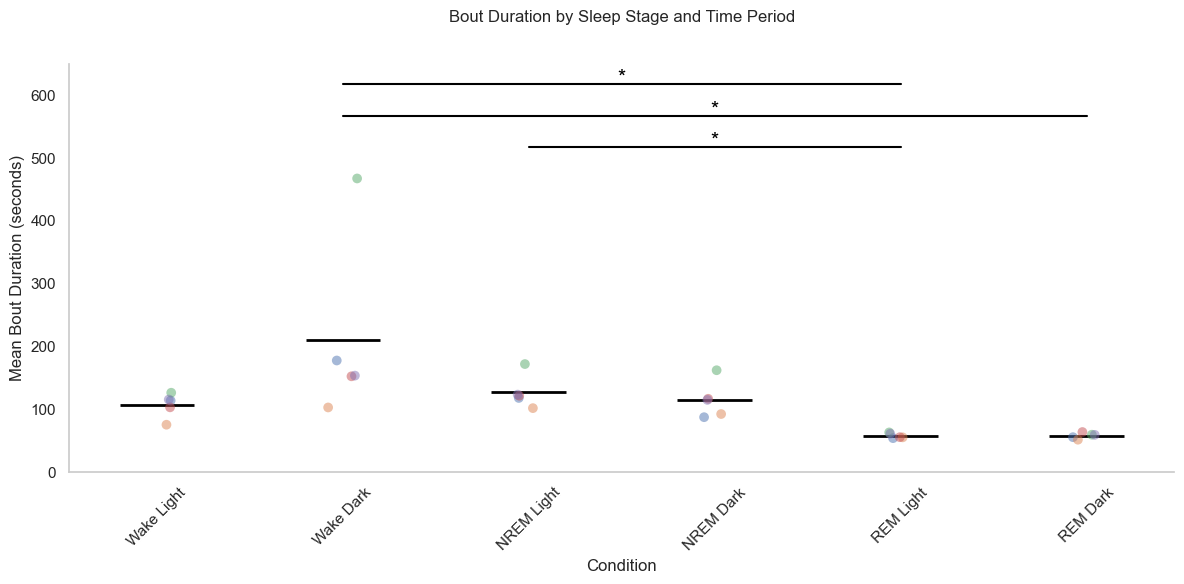

In [92]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import kruskal
from scikit_posthocs import posthoc_dunn

# List of CSV file paths
csv_files = glob.glob('/Volumes/harris/volkan/sleep_profile/downsample_auto_score/bout_duration/*.csv')

# Dictionary to store results
results = {}

for file in csv_files:
    # Load the CSV file
    df = pd.read_csv(file)
    
    # Convert Timestamp column to datetime format
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Round the numbers in the sleepStage column to the nearest integer
    df['sleepStage'] = df['sleepStage'].round().astype(int)
    
    # Create a new column to track changes in sleep stage
    df['sleepStageChange'] = df['sleepStage'] != df['sleepStage'].shift()
    
    # Create a cumulative sum of changes to identify continuous instances
    df['boutId'] = df['sleepStageChange'].cumsum()
    
    # Determine the time period (light or dark) for each row
    def get_time_period(row):
        hour = row['Timestamp'].hour
        if 9 <= hour < 21:
            return 'Light'
        else:
            return 'Dark'
    
    df['timePeriod'] = df.apply(get_time_period, axis=1)
    
    # Group by boutId and sleepStage, then calculate the count of rows for each bout
    bout_durations = df.groupby(['boutId', 'sleepStage']).size().reset_index(name='boutDuration')
    
    # Map sleep stages to their corresponding names
    sleep_stage_map = {1: 'Wake', 2: 'NREM', 3: 'REM'}
    bout_durations['sleepStage'] = bout_durations['sleepStage'].map(sleep_stage_map)
    
    # Determine the time period for each bout based on the majority time
    bout_time_periods = df.groupby('boutId')['timePeriod'].apply(lambda x: x.value_counts().index[0]).reset_index()
    
    # Merge the bout durations with the time periods
    bout_durations = pd.merge(bout_durations, bout_time_periods, on='boutId')
    
    # Group by timePeriod and sleepStage, then calculate the mean bout duration
    light_dark_avg_duration_stages = bout_durations.groupby(['timePeriod', 'sleepStage'])['boutDuration'].mean()
    
    # Store results in dictionary
    filename = file.split('/')[-1]
    results[filename] = {
        'bout_durations': bout_durations,
        'light_dark_avg_duration_stages': light_dark_avg_duration_stages,
    }

# Prepare data for plotting
conditions = ['Wake Light', 'Wake Dark', 'NREM Light', 'NREM Dark', 'REM Light', 'REM Dark']
stripplot_data = {cond: [] for cond in conditions}
subject_labels = []  # To store subject labels for hue

# For each condition, collect individual subject means (i.e., for each file)
for time_period, sleep_stage in [('Light', 'Wake'), ('Dark', 'Wake'), 
                                 ('Light', 'NREM'), ('Dark', 'NREM'), 
                                 ('Light', 'REM'), ('Dark', 'REM')]:
    condition = f'{sleep_stage} {time_period}'

    # Collect the individual means for the condition across all files
    for i, (filename, result) in enumerate(results.items()):
        try:
            mean = result['light_dark_avg_duration_stages'].loc[(time_period, sleep_stage)]
            stripplot_data[condition].append(mean)
            subject_labels.append(f'Subject {i+1}')  # Assign a label for each subject
        except KeyError:
            stripplot_data[condition].append(np.nan)
            subject_labels.append(f'Subject {i+1}')

# Convert subject labels and data to a DataFrame for seaborn to handle the hue
plot_data = pd.DataFrame({
    'Condition': [cond for cond in conditions for _ in range(len(csv_files))],
    'MeanBoutDuration': [item for sublist in stripplot_data.values() for item in sublist],
    'Subject': subject_labels
})

# Kruskal-Wallis test (non-parametric ANOVA alternative)
anova_data = plot_data[['Condition', 'MeanBoutDuration']]

# Kruskal-Wallis test for each condition
grouped_data = [anova_data[anova_data['Condition'] == cond]['MeanBoutDuration'] for cond in conditions]
kruskal_result = kruskal(*grouped_data)

# Print Kruskal-Wallis result
print("Kruskal-Wallis Test Results:")
print(f"Test statistic: {kruskal_result.statistic}")
print(f"P-value: {kruskal_result.pvalue}")

# If Kruskal-Wallis test is significant, perform pairwise Dunn's test
if kruskal_result.pvalue < 0.05:
    print("\nPost-hoc Pairwise Comparison using Dunn's Test:")
    dunn_result = posthoc_dunn(anova_data, val_col='MeanBoutDuration', group_col='Condition', p_adjust='bonferroni')
    print(dunn_result)

    # Get the significant comparisons from Dunn's test (p < 0.05)
    significant_comparisons = dunn_result[dunn_result < 0.05].stack().index.tolist()

# Plot
plt.figure(figsize=(12, 6))

# Create stripplot with 'hue' for different subjects
sns.stripplot(x='Condition', y='MeanBoutDuration', data=plot_data, jitter=0.08, hue='Subject', alpha=0.5, size=7, legend=False)

# Plot mean as a horizontal line for each condition
for i, cond in enumerate(conditions):
    condition_data = plot_data[plot_data['Condition'] == cond]
    condition_mean = condition_data['MeanBoutDuration'].mean()
    plt.hlines(condition_mean, i - 0.2, i + 0.2, color='black', linestyle='-', linewidth=2)

# Set initial offset above the y_max for the first comparison
y_max = plot_data['MeanBoutDuration'].max()
comparison_offset = y_max + 50  # Space above the maximum value of the y-axis for the first comparison

# Track comparisons to avoid duplicating
shown_comparisons = set()

# Add asterisks for significant post-hoc comparisons
for comparison in significant_comparisons:
    cond1, cond2 = comparison
    # Ensure comparisons are ordered to avoid duplicates (e.g., 'A vs B' and 'B vs A' should not both be shown)
    comparison_pair = tuple(sorted([cond1, cond2]))

    # Check if the comparison has already been shown
    if comparison_pair not in shown_comparisons:
        idx1 = conditions.index(cond1)
        idx2 = conditions.index(cond2)
        
        # Plot a line between the two conditions
        plt.plot([idx1, idx2], [comparison_offset, comparison_offset], color='black', lw=1.5)
        plt.text((idx1 + idx2) / 2, comparison_offset + 0.05, "*", ha='center', fontsize=15, color='black')

        # Add the comparison to the set to ensure it's not repeated
        shown_comparisons.add(comparison_pair)

        # Increase the offset for the next comparison to move it higher
        comparison_offset += 50  # Increase the gap for the next comparison

# Customize plot
plt.xticks(rotation=45)
plt.ylabel('Mean Bout Duration (seconds)')
plt.ylim(0, 650)  # Set y-axis range
plt.yticks(np.arange(0, 650, 100))  # Set y-axis ticks every 100
plt.title('Bout Duration by Sleep Stage and Time Period', pad=30)

# Remove top and right spines
sns.despine(top=True, right=True)


plt.grid(axis='y', linestyle='--', alpha=0) # Hide grid
plt.tight_layout()
plt.show()



Kruskal-Wallis Test Results:
Test statistic: 21.774193548387117
P-value: 0.0005779550784272325

Post-hoc Pairwise Comparison using Dunn's Test:
            NREM Dark  NREM Light  REM Dark  REM Light  Wake Dark  Wake Light
NREM Dark    1.000000    1.000000  0.426576   0.322618   1.000000    1.000000
NREM Light   1.000000    1.000000  0.068146   0.048361   1.000000    1.000000
REM Dark     0.426576    0.068146  1.000000   1.000000   0.008458    0.558192
REM Light    0.322618    0.048361  1.000000   1.000000   0.005644    0.426576
Wake Dark    1.000000    1.000000  0.008458   0.005644   1.000000    1.000000
Wake Light   1.000000    1.000000  0.558192   0.426576   1.000000    1.000000


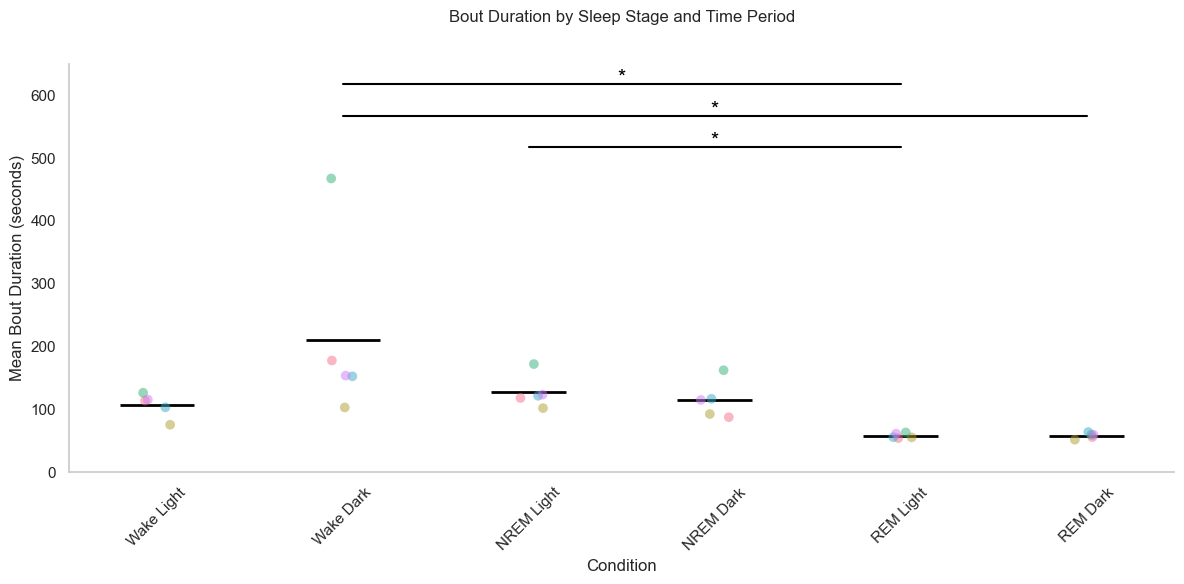

In [93]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import kruskal
from scikit_posthocs import posthoc_dunn

# List of CSV file paths
csv_files = glob.glob('/Volumes/harris/volkan/sleep_profile/downsample_auto_score/bout_duration/*.csv')

# Dictionary to store results
results = {}

for file in csv_files:
    # Load the CSV file
    df = pd.read_csv(file)
    
    # Convert Timestamp column to datetime format
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Round the numbers in the sleepStage column to the nearest integer
    df['sleepStage'] = df['sleepStage'].round().astype(int)
    
    # Create a new column to track changes in sleep stage
    df['sleepStageChange'] = df['sleepStage'] != df['sleepStage'].shift()
    
    # Create a cumulative sum of changes to identify continuous instances
    df['boutId'] = df['sleepStageChange'].cumsum()
    
    # Determine the time period (light or dark) for each row
    def get_time_period(row):
        hour = row['Timestamp'].hour
        if 9 <= hour < 21:
            return 'Light'
        else:
            return 'Dark'
    
    df['timePeriod'] = df.apply(get_time_period, axis=1)
    
    # Group by boutId and sleepStage, then calculate the count of rows for each bout
    bout_durations = df.groupby(['boutId', 'sleepStage']).size().reset_index(name='boutDuration')
    
    # Map sleep stages to their corresponding names
    sleep_stage_map = {1: 'Wake', 2: 'NREM', 3: 'REM'}
    bout_durations['sleepStage'] = bout_durations['sleepStage'].map(sleep_stage_map)
    
    # Determine the time period for each bout based on the majority time
    bout_time_periods = df.groupby('boutId')['timePeriod'].apply(lambda x: x.value_counts().index[0]).reset_index()
    
    # Merge the bout durations with the time periods
    bout_durations = pd.merge(bout_durations, bout_time_periods, on='boutId')
    
    # Group by timePeriod and sleepStage, then calculate the mean bout duration
    light_dark_avg_duration_stages = bout_durations.groupby(['timePeriod', 'sleepStage'])['boutDuration'].mean()
    
    # Store results in dictionary
    filename = file.split('/')[-1]
    results[filename] = {
        'bout_durations': bout_durations,
        'light_dark_avg_duration_stages': light_dark_avg_duration_stages,
    }

# Prepare data for plotting
conditions = ['Wake Light', 'Wake Dark', 'NREM Light', 'NREM Dark', 'REM Light', 'REM Dark']
stripplot_data = {cond: [] for cond in conditions}
subject_labels = []  # To store subject labels for hue

# For each condition, collect individual subject means (i.e., for each file)
for time_period, sleep_stage in [('Light', 'Wake'), ('Dark', 'Wake'), 
                                 ('Light', 'NREM'), ('Dark', 'NREM'), 
                                 ('Light', 'REM'), ('Dark', 'REM')]:
    condition = f'{sleep_stage} {time_period}'

    # Collect the individual means for the condition across all files
    for i, (filename, result) in enumerate(results.items()):
        try:
            mean = result['light_dark_avg_duration_stages'].loc[(time_period, sleep_stage)]
            stripplot_data[condition].append(mean)
            subject_labels.append(f'Subject {i+1}')  # Assign a label for each subject
        except KeyError:
            stripplot_data[condition].append(np.nan)
            subject_labels.append(f'Subject {i+1}')

# Convert subject labels and data to a DataFrame for seaborn to handle the hue
plot_data = pd.DataFrame({
    'Condition': [cond for cond in conditions for _ in range(len(csv_files))],
    'MeanBoutDuration': [item for sublist in stripplot_data.values() for item in sublist],
    'Subject': subject_labels
})

# Assign consistent colors to each subject
unique_subjects = plot_data['Subject'].unique()
subject_palette = sns.color_palette("husl", len(unique_subjects))  # Assign distinct colors for subjects
subject_color_map = {subject: color for subject, color in zip(unique_subjects, subject_palette)}

# Kruskal-Wallis test (non-parametric ANOVA alternative)
anova_data = plot_data[['Condition', 'MeanBoutDuration']]

# Kruskal-Wallis test for each condition
grouped_data = [anova_data[anova_data['Condition'] == cond]['MeanBoutDuration'] for cond in conditions]
kruskal_result = kruskal(*grouped_data)

# Print Kruskal-Wallis result
print("Kruskal-Wallis Test Results:")
print(f"Test statistic: {kruskal_result.statistic}")
print(f"P-value: {kruskal_result.pvalue}")

# If Kruskal-Wallis test is significant, perform pairwise Dunn's test
if kruskal_result.pvalue < 0.05:
    print("\nPost-hoc Pairwise Comparison using Dunn's Test:")
    dunn_result = posthoc_dunn(anova_data, val_col='MeanBoutDuration', group_col='Condition', p_adjust='bonferroni')
    print(dunn_result)

    # Get the significant comparisons from Dunn's test (p < 0.05)
    significant_comparisons = dunn_result[dunn_result < 0.05].stack().index.tolist()

# Plot
plt.figure(figsize=(12, 6))

# Create stripplot with 'hue' for different subjects, using the consistent color map
sns.stripplot(x='Condition', y='MeanBoutDuration', data=plot_data, jitter=0.08, hue='Subject', palette=subject_color_map, alpha=0.5, size=7, legend=False)

# Plot mean as a horizontal line for each condition
for i, cond in enumerate(conditions):
    condition_data = plot_data[plot_data['Condition'] == cond]
    condition_mean = condition_data['MeanBoutDuration'].mean()
    plt.hlines(condition_mean, i - 0.2, i + 0.2, color='black', linestyle='-', linewidth=2)

# Set initial offset above the y_max for the first comparison
y_max = plot_data['MeanBoutDuration'].max()
comparison_offset = y_max + 50  # Space above the maximum value of the y-axis for the first comparison

# Track comparisons to avoid duplicating
shown_comparisons = set()

# Add asterisks for significant post-hoc comparisons
for comparison in significant_comparisons:
    cond1, cond2 = comparison
    # Ensure comparisons are ordered to avoid duplicates (e.g., 'A vs B' and 'B vs A' should not both be shown)
    comparison_pair = tuple(sorted([cond1, cond2]))

    # Check if the comparison has already been shown
    if comparison_pair not in shown_comparisons:
        idx1 = conditions.index(cond1)
        idx2 = conditions.index(cond2)
        
        # Plot a line between the two conditions
        plt.plot([idx1, idx2], [comparison_offset, comparison_offset], color='black', lw=1.5)
        plt.text((idx1 + idx2) / 2, comparison_offset + 0.05, "*", ha='center', fontsize=15, color='black')

        # Add the comparison to the set to ensure it's not repeated
        shown_comparisons.add(comparison_pair)

        # Increase the offset for the next comparison to move it higher
        comparison_offset += 50  # Increase the gap for the next comparison

# Customize plot
plt.xticks(rotation=45)
plt.ylabel('Mean Bout Duration (seconds)')
plt.ylim(0, 650)  # Set y-axis range
plt.yticks(np.arange(0, 650, 100))  # Set y-axis ticks every 100
plt.title('Bout Duration by Sleep Stage and Time Period', pad=30)

# Remove top and right spines
sns.despine(top=True, right=True)

plt.grid(axis='y', linestyle='--', alpha=0) # Hide grid
plt.tight_layout()
plt.show()


Kruskal-Wallis Test Results:
Test statistic: 21.774193548387117
P-value: 0.0005779550784272325

Post-hoc Pairwise Comparison using Dunn's Test:
            NREM Dark  NREM Light  REM Dark  REM Light  Wake Dark  Wake Light
NREM Dark    1.000000    1.000000  0.426576   0.322618   1.000000    1.000000
NREM Light   1.000000    1.000000  0.068146   0.048361   1.000000    1.000000
REM Dark     0.426576    0.068146  1.000000   1.000000   0.008458    0.558192
REM Light    0.322618    0.048361  1.000000   1.000000   0.005644    0.426576
Wake Dark    1.000000    1.000000  0.008458   0.005644   1.000000    1.000000
Wake Light   1.000000    1.000000  0.558192   0.426576   1.000000    1.000000


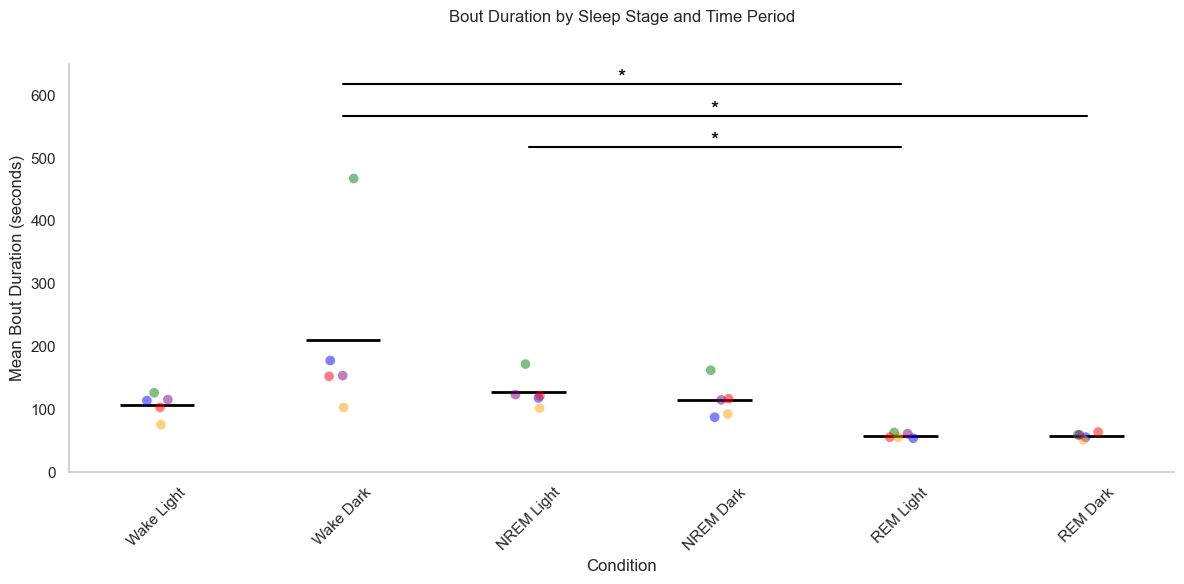

In [97]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import kruskal
from scikit_posthocs import posthoc_dunn

# List of CSV file paths
csv_files = glob.glob('/Volumes/harris/volkan/sleep_profile/downsample_auto_score/bout_duration/*.csv')

# Dictionary to store results
results = {}

# Initialize a list to hold the subject labels
subject_labels = []

# Define conditions
conditions = ['Wake Light', 'Wake Dark', 'NREM Light', 'NREM Dark', 'REM Light', 'REM Dark']

for file in csv_files:
    # Prompt for which subject this CSV file corresponds to
    subject_name = input(f"Enter the subject name for the file {file}: ")

    # Load the CSV file
    df = pd.read_csv(file)
    
    # Convert Timestamp column to datetime format
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Round the numbers in the sleepStage column to the nearest integer
    df['sleepStage'] = df['sleepStage'].round().astype(int)
    
    # Create a new column to track changes in sleep stage
    df['sleepStageChange'] = df['sleepStage'] != df['sleepStage'].shift()
    
    # Create a cumulative sum of changes to identify continuous instances
    df['boutId'] = df['sleepStageChange'].cumsum()
    
    # Determine the time period (light or dark) for each row
    def get_time_period(row):
        hour = row['Timestamp'].hour
        if 9 <= hour < 21:
            return 'Light'
        else:
            return 'Dark'
    
    df['timePeriod'] = df.apply(get_time_period, axis=1)
    
    # Group by boutId and sleepStage, then calculate the count of rows for each bout
    bout_durations = df.groupby(['boutId', 'sleepStage']).size().reset_index(name='boutDuration')
    
    # Map sleep stages to their corresponding names
    sleep_stage_map = {1: 'Wake', 2: 'NREM', 3: 'REM'}
    bout_durations['sleepStage'] = bout_durations['sleepStage'].map(sleep_stage_map)
    
    # Determine the time period for each bout based on the majority time
    bout_time_periods = df.groupby('boutId')['timePeriod'].apply(lambda x: x.value_counts().index[0]).reset_index()
    
    # Merge the bout durations with the time periods
    bout_durations = pd.merge(bout_durations, bout_time_periods, on='boutId')
    
    # Group by timePeriod and sleepStage, then calculate the mean bout duration
    light_dark_avg_duration_stages = bout_durations.groupby(['timePeriod', 'sleepStage'])['boutDuration'].mean()
    
    # Store results in dictionary, using subject name as the key
    results[subject_name] = {
        'bout_durations': bout_durations,
        'light_dark_avg_duration_stages': light_dark_avg_duration_stages,
    }

    # Add the subject name to the labels for later plotting
    subject_labels.extend([subject_name] * len(bout_durations))

# Prepare data for plotting
stripplot_data = {cond: [] for cond in conditions}
subject_labels_plot = []  # List for subject labels corresponding to the plot

# Collect data for each condition
for time_period, sleep_stage in [('Light', 'Wake'), ('Dark', 'Wake'), 
                                 ('Light', 'NREM'), ('Dark', 'NREM'), 
                                 ('Light', 'REM'), ('Dark', 'REM')]:
    condition = f'{sleep_stage} {time_period}'
    
    # Collect the individual means for the condition across all subjects
    for subject_name, result in results.items():
        try:
            mean = result['light_dark_avg_duration_stages'].loc[(time_period, sleep_stage)]
            stripplot_data[condition].append(mean)
            subject_labels_plot.append(subject_name)
        except KeyError:
            stripplot_data[condition].append(np.nan)
            subject_labels_plot.append(subject_name)

# Convert subject labels and data to a DataFrame for seaborn to handle the hue
plot_data = pd.DataFrame({
    'Condition': [cond for cond in conditions for _ in range(len(results))],
    'MeanBoutDuration': [item for sublist in stripplot_data.values() for item in sublist],
    'Subject': subject_labels_plot
})

# Ask the user to define colors for each subject
subject_palette = {}
for subject in plot_data['Subject'].unique():
    color = input(f"Enter a color for subject '{subject}': ")
    subject_palette[subject] = color

# Kruskal-Wallis test (non-parametric ANOVA alternative)
anova_data = plot_data[['Condition', 'MeanBoutDuration']]

# Kruskal-Wallis test for each condition
grouped_data = [anova_data[anova_data['Condition'] == cond]['MeanBoutDuration'] for cond in conditions]
kruskal_result = kruskal(*grouped_data)

# Print Kruskal-Wallis result
print("Kruskal-Wallis Test Results:")
print(f"Test statistic: {kruskal_result.statistic}")
print(f"P-value: {kruskal_result.pvalue}")

# If Kruskal-Wallis test is significant, perform pairwise Dunn's test
if kruskal_result.pvalue < 0.05:
    print("\nPost-hoc Pairwise Comparison using Dunn's Test:")
    dunn_result = posthoc_dunn(anova_data, val_col='MeanBoutDuration', group_col='Condition', p_adjust='bonferroni')
    print(dunn_result)

    # Get the significant comparisons from Dunn's test (p < 0.05)
    significant_comparisons = dunn_result[dunn_result < 0.05].stack().index.tolist()

# Plot
plt.figure(figsize=(12, 6))

# Create stripplot with 'hue' for different subjects, using the user-defined color map
sns.stripplot(x='Condition', y='MeanBoutDuration', data=plot_data, jitter=0.08, hue='Subject', palette=subject_palette, alpha=0.5, size=7, legend=False)

# Plot mean as a horizontal line for each condition
for i, cond in enumerate(conditions):
    condition_data = plot_data[plot_data['Condition'] == cond]
    condition_mean = condition_data['MeanBoutDuration'].mean()
    plt.hlines(condition_mean, i - 0.2, i + 0.2, color='black', linestyle='-', linewidth=2)

# Set initial offset above the y_max for the first comparison
y_max = plot_data['MeanBoutDuration'].max()
comparison_offset = y_max + 50  # Space above the maximum value of the y-axis for the first comparison

# Track comparisons to avoid duplicating
shown_comparisons = set()

# Add asterisks for significant post-hoc comparisons
for comparison in significant_comparisons:
    cond1, cond2 = comparison
    # Ensure comparisons are ordered to avoid duplicates (e.g., 'A vs B' and 'B vs A' should not both be shown)
    comparison_pair = tuple(sorted([cond1, cond2]))

    # Check if the comparison has already been shown
    if comparison_pair not in shown_comparisons:
        idx1 = conditions.index(cond1)
        idx2 = conditions.index(cond2)
        
        # Plot a line between the two conditions
        plt.plot([idx1, idx2], [comparison_offset, comparison_offset], color='black', lw=1.5)
        plt.text((idx1 + idx2) / 2, comparison_offset + 0.05, "*", ha='center', fontsize=15, color='black')

        # Add the comparison to the set to ensure it's not repeated
        shown_comparisons.add(comparison_pair)

        # Increase the offset for the next comparison to move it higher
        comparison_offset += 50  # Increase the gap for the next comparison

# Customize plot
plt.xticks(rotation=45)
plt.ylabel('Mean Bout Duration (seconds)')
plt.ylim(0, 650)  # Set y-axis range
plt.yticks(np.arange(0, 650, 100))  # Set y-axis ticks every 100
plt.title('Bout Duration by Sleep Stage and Time Period', pad=30)

# Remove top and right spines
sns.despine(top=True, right=True)

plt.grid(axis='y', linestyle='--', alpha=0) # Hide grid
plt.tight_layout()
plt.show()


2-Way ANOVA Results:
                     sum_sq    df          F    PR(>F)
C(Condition)  959228.312288   5.0  11.528879  0.000009
Residual      399370.638568  24.0        NaN       NaN

Tukey's Post-Hoc Test Results:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
  group1     group2    meandiff p-adj    lower    upper   reject
----------------------------------------------------------------
 NREM Dark NREM Light   -7.5346    1.0  -259.791 244.7218  False
 NREM Dark   REM Dark -262.0665 0.0385 -514.3229  -9.8101   True
 NREM Dark  REM Light -262.1607 0.0384 -514.4172  -9.9043   True
 NREM Dark  Wake Dark   262.268 0.0383   10.0116 514.5245   True
 NREM Dark Wake Light  -41.7674 0.9952 -294.0238  210.489  False
NREM Light   REM Dark -254.5319 0.0471 -506.7883  -2.2755   True
NREM Light  REM Light -254.6261  0.047 -506.8826  -2.3697   True
NREM Light  Wake Dark  269.8026 0.0312   17.5462 522.0591   True
NREM Light Wake Light  -34.2328 0.9981 -286.4892 218.0236  False
  

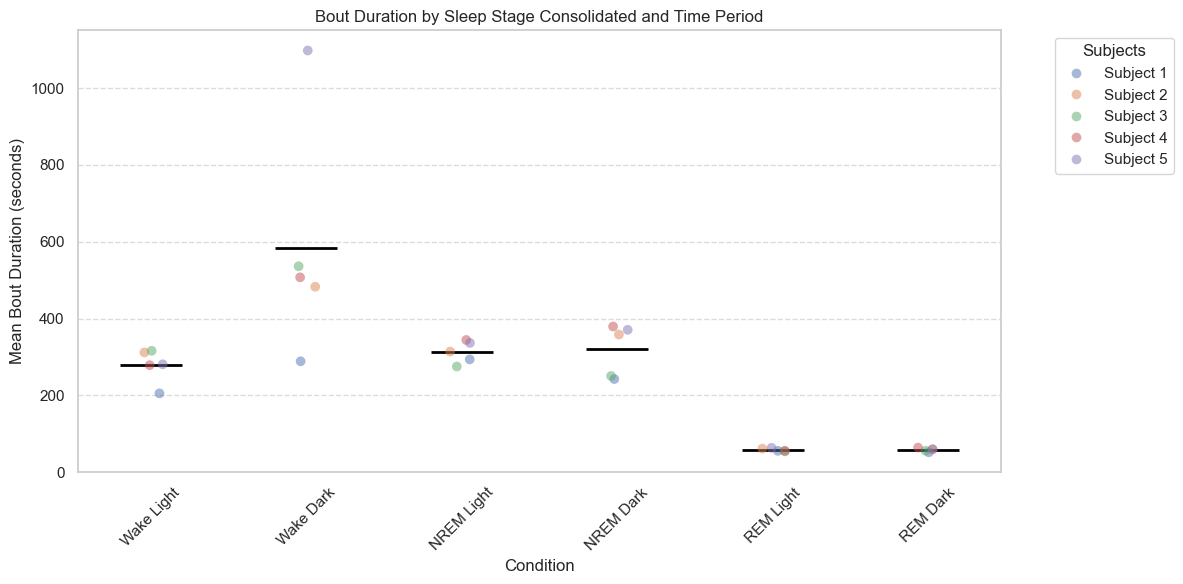

In [39]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# List of CSV file paths
csv_files = glob.glob('/Volumes/harris/volkan/sleep_profile/downsample_auto_score/bout_duration_consolidated/*.csv')

# Dictionary to store results
results = {}

for file in csv_files:
    # Load the CSV file
    df = pd.read_csv(file)
    
    # Convert Timestamp column to datetime format
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Round the numbers in the sleepStageConsolidated column to the nearest integer
    df['sleepStageConsolidated'] = df['sleepStageConsolidated'].round().astype(int)
    
    # Create a new column to track changes in sleep stage
    df['sleepStageConsolidatedChange'] = df['sleepStageConsolidated'] != df['sleepStageConsolidated'].shift()
    
    # Create a cumulative sum of changes to identify continuous instances
    df['boutId'] = df['sleepStageConsolidatedChange'].cumsum()
    
    # Determine the time period (light or dark) for each row
    def get_time_period(row):
        hour = row['Timestamp'].hour
        if 9 <= hour < 21:
            return 'Light'
        else:
            return 'Dark'
    
    df['timePeriod'] = df.apply(get_time_period, axis=1)
    
    # Group by boutId and sleepStageConsolidated, then calculate the count of rows for each bout
    bout_durations = df.groupby(['boutId', 'sleepStageConsolidated']).size().reset_index(name='boutDuration')
    
    # Map sleep stages to their corresponding names
    sleep_stage_map = {1: 'Wake', 2: 'NREM', 3: 'REM'}
    bout_durations['sleepStageConsolidated'] = bout_durations['sleepStageConsolidated'].map(sleep_stage_map)
    
    # Determine the time period for each bout based on the majority time
    bout_time_periods = df.groupby('boutId')['timePeriod'].apply(lambda x: x.value_counts().index[0]).reset_index()
    
    # Merge the bout durations with the time periods
    bout_durations = pd.merge(bout_durations, bout_time_periods, on='boutId')
    
    # Group by timePeriod and sleepStageConsolidated, then calculate the mean bout duration
    light_dark_avg_duration_stages = bout_durations.groupby(['timePeriod', 'sleepStageConsolidated'])['boutDuration'].mean()
    
    # Store results in dictionary
    filename = file.split('/')[-1]
    results[filename] = {
        'bout_durations': bout_durations,
        'light_dark_avg_duration_stages': light_dark_avg_duration_stages,
    }

# Prepare data for plotting
conditions = ['Wake Light', 'Wake Dark', 'NREM Light', 'NREM Dark', 'REM Light', 'REM Dark']
stripplot_data = {cond: [] for cond in conditions}
subject_labels = []  # To store subject labels for hue

# For each condition, collect individual subject means (i.e., for each file)
for time_period, sleep_stage in [('Light', 'Wake'), ('Dark', 'Wake'), 
                                 ('Light', 'NREM'), ('Dark', 'NREM'), 
                                 ('Light', 'REM'), ('Dark', 'REM')]:
    condition = f'{sleep_stage} {time_period}'

    # Collect the individual means for the condition across all files
    for i, (filename, result) in enumerate(results.items()):
        try:
            mean = result['light_dark_avg_duration_stages'].loc[(time_period, sleep_stage)]
            stripplot_data[condition].append(mean)
            subject_labels.append(f'Subject {i+1}')  # Assign a label for each subject
        except KeyError:
            stripplot_data[condition].append(np.nan)
            subject_labels.append(f'Subject {i+1}')

# Convert subject labels and data to a DataFrame for seaborn to handle the hue
plot_data = pd.DataFrame({
    'Condition': [cond for cond in conditions for _ in range(len(csv_files))],
    'MeanBoutDuration': [item for sublist in stripplot_data.values() for item in sublist],
    'Subject': subject_labels
})

# Prepare for ANOVA
anova_data = plot_data[['Condition', 'MeanBoutDuration']]

# Run the 2-way ANOVA
model = ols('MeanBoutDuration ~ C(Condition)', data=anova_data).fit()
anova_result = anova_lm(model, typ=2)

# Print the ANOVA result
print("2-Way ANOVA Results:")
print(anova_result)

# Tukey's HSD Post-hoc test
tukey_result = pairwise_tukeyhsd(endog=anova_data['MeanBoutDuration'], 
                                 groups=anova_data['Condition'], 
                                 alpha=0.05)

# Print Tukey's HSD results
print("\nTukey's Post-Hoc Test Results:")
print(tukey_result)

# Plot
plt.figure(figsize=(12, 6))

# Create stripplot with 'hue' for different subjects
sns.stripplot(x='Condition', y='MeanBoutDuration', data=plot_data, jitter=0.08, hue='Subject', alpha=0.5, size=7)

# Plot mean as a horizontal line for each condition
for i, cond in enumerate(conditions):
    condition_data = plot_data[plot_data['Condition'] == cond]
    condition_mean = condition_data['MeanBoutDuration'].mean()
    plt.hlines(condition_mean, i - 0.2, i + 0.2, color='black', linestyle='-', linewidth=2)

# Customize plot
plt.xticks(rotation=45)
plt.ylabel('Mean Bout Duration (seconds)')
plt.title('Bout Duration by Sleep Stage Consolidated and Time Period')

# Customize legend to show subjects
plt.legend(title='Subjects', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Kruskal-Wallis Test Results:
Test statistic: 22.64129032258066
P-value: 0.00039524482377953016

Post-hoc Pairwise Comparison using Dunn's Test:
            NREM Dark  NREM Light  REM Dark  REM Light  Wake Dark  Wake Light
NREM Dark    1.000000    1.000000  0.161401   0.117853   1.000000    1.000000
NREM Light   1.000000    1.000000  0.218709   0.161401   1.000000    1.000000
REM Dark     0.161401    0.218709  1.000000   1.000000   0.003725    0.854012
REM Light    0.117853    0.161401  1.000000   1.000000   0.002432    0.663964
Wake Dark    1.000000    1.000000  0.003725   0.002432   1.000000    1.000000
Wake Light   1.000000    1.000000  0.854012   0.663964   1.000000    1.000000


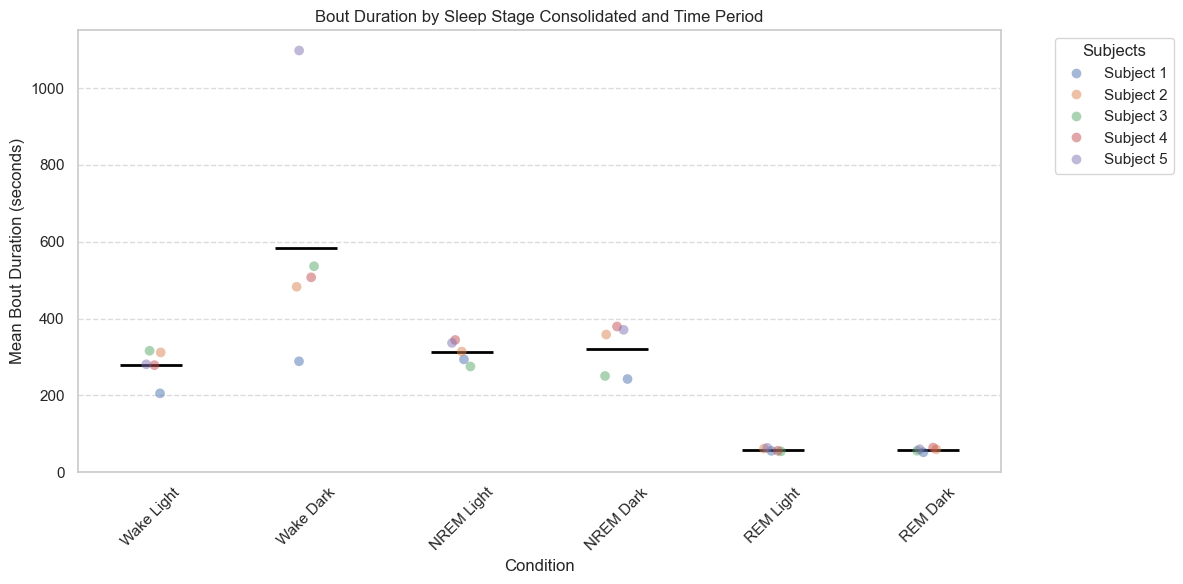

In [45]:
## Use of Kruskal-Wallis and Dunn test due to non-parametric distribution of data

import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import kruskal
from scikit_posthocs import posthoc_dunn

# List of CSV file paths
csv_files = glob.glob('/Volumes/harris/volkan/sleep_profile/downsample_auto_score/bout_duration_consolidated/*.csv')

# Dictionary to store results
results = {}

for file in csv_files:
    # Load the CSV file
    df = pd.read_csv(file)
    
    # Convert Timestamp column to datetime format
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Round the numbers in the sleepStageConsolidated column to the nearest integer
    df['sleepStageConsolidated'] = df['sleepStageConsolidated'].round().astype(int)
    
    # Create a new column to track changes in sleep stage
    df['sleepStageConsolidatedChange'] = df['sleepStageConsolidated'] != df['sleepStageConsolidated'].shift()
    
    # Create a cumulative sum of changes to identify continuous instances
    df['boutId'] = df['sleepStageConsolidatedChange'].cumsum()
    
    # Determine the time period (light or dark) for each row
    def get_time_period(row):
        hour = row['Timestamp'].hour
        if 9 <= hour < 21:
            return 'Light'
        else:
            return 'Dark'
    
    df['timePeriod'] = df.apply(get_time_period, axis=1)
    
    # Group by boutId and sleepStageConsolidated, then calculate the count of rows for each bout
    bout_durations = df.groupby(['boutId', 'sleepStageConsolidated']).size().reset_index(name='boutDuration')
    
    # Map sleep stages to their corresponding names
    sleep_stage_map = {1: 'Wake', 2: 'NREM', 3: 'REM'}
    bout_durations['sleepStageConsolidated'] = bout_durations['sleepStageConsolidated'].map(sleep_stage_map)
    
    # Determine the time period for each bout based on the majority time
    bout_time_periods = df.groupby('boutId')['timePeriod'].apply(lambda x: x.value_counts().index[0]).reset_index()
    
    # Merge the bout durations with the time periods
    bout_durations = pd.merge(bout_durations, bout_time_periods, on='boutId')
    
    # Group by timePeriod and sleepStageConsolidated, then calculate the mean bout duration
    light_dark_avg_duration_stages = bout_durations.groupby(['timePeriod', 'sleepStageConsolidated'])['boutDuration'].mean()
    
    # Store results in dictionary
    filename = file.split('/')[-1]
    results[filename] = {
        'bout_durations': bout_durations,
        'light_dark_avg_duration_stages': light_dark_avg_duration_stages,
    }

# Prepare data for plotting
conditions = ['Wake Light', 'Wake Dark', 'NREM Light', 'NREM Dark', 'REM Light', 'REM Dark']
stripplot_data = {cond: [] for cond in conditions}
subject_labels = []  # To store subject labels for hue

# For each condition, collect individual subject means (i.e., for each file)
for time_period, sleep_stage in [('Light', 'Wake'), ('Dark', 'Wake'), 
                                 ('Light', 'NREM'), ('Dark', 'NREM'), 
                                 ('Light', 'REM'), ('Dark', 'REM')]:
    condition = f'{sleep_stage} {time_period}'

    # Collect the individual means for the condition across all files
    for i, (filename, result) in enumerate(results.items()):
        try:
            mean = result['light_dark_avg_duration_stages'].loc[(time_period, sleep_stage)]
            stripplot_data[condition].append(mean)
            subject_labels.append(f'Subject {i+1}')  # Assign a label for each subject
        except KeyError:
            stripplot_data[condition].append(np.nan)
            subject_labels.append(f'Subject {i+1}')

# Convert subject labels and data to a DataFrame for seaborn to handle the hue
plot_data = pd.DataFrame({
    'Condition': [cond for cond in conditions for _ in range(len(csv_files))],
    'MeanBoutDuration': [item for sublist in stripplot_data.values() for item in sublist],
    'Subject': subject_labels
})

# Kruskal-Wallis test (non-parametric ANOVA alternative)
anova_data = plot_data[['Condition', 'MeanBoutDuration']]

# Kruskal-Wallis test for each condition
grouped_data = [anova_data[anova_data['Condition'] == cond]['MeanBoutDuration'] for cond in conditions]
kruskal_result = kruskal(*grouped_data)

# Print Kruskal-Wallis result
print("Kruskal-Wallis Test Results:")
print(f"Test statistic: {kruskal_result.statistic}")
print(f"P-value: {kruskal_result.pvalue}")

# If Kruskal-Wallis test is significant, perform pairwise Dunn's test
if kruskal_result.pvalue < 0.05:
    print("\nPost-hoc Pairwise Comparison using Dunn's Test:")
    dunn_result = posthoc_dunn(anova_data, val_col='MeanBoutDuration', group_col='Condition', p_adjust='bonferroni')
    print(dunn_result)

# Plot
plt.figure(figsize=(12, 6))

# Create stripplot with 'hue' for different subjects
sns.stripplot(x='Condition', y='MeanBoutDuration', data=plot_data, jitter=0.08, hue='Subject', alpha=0.5, size=7)

# Plot mean as a horizontal line for each condition
for i, cond in enumerate(conditions):
    condition_data = plot_data[plot_data['Condition'] == cond]
    condition_mean = condition_data['MeanBoutDuration'].mean()
    plt.hlines(condition_mean, i - 0.2, i + 0.2, color='black', linestyle='-', linewidth=2)

# Customize plot
plt.xticks(rotation=45)
plt.ylabel('Mean Bout Duration (seconds)')
plt.title('Bout Duration by Sleep Stage Consolidated and Time Period')

# Customize legend to show subjects
plt.legend(title='Subjects', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


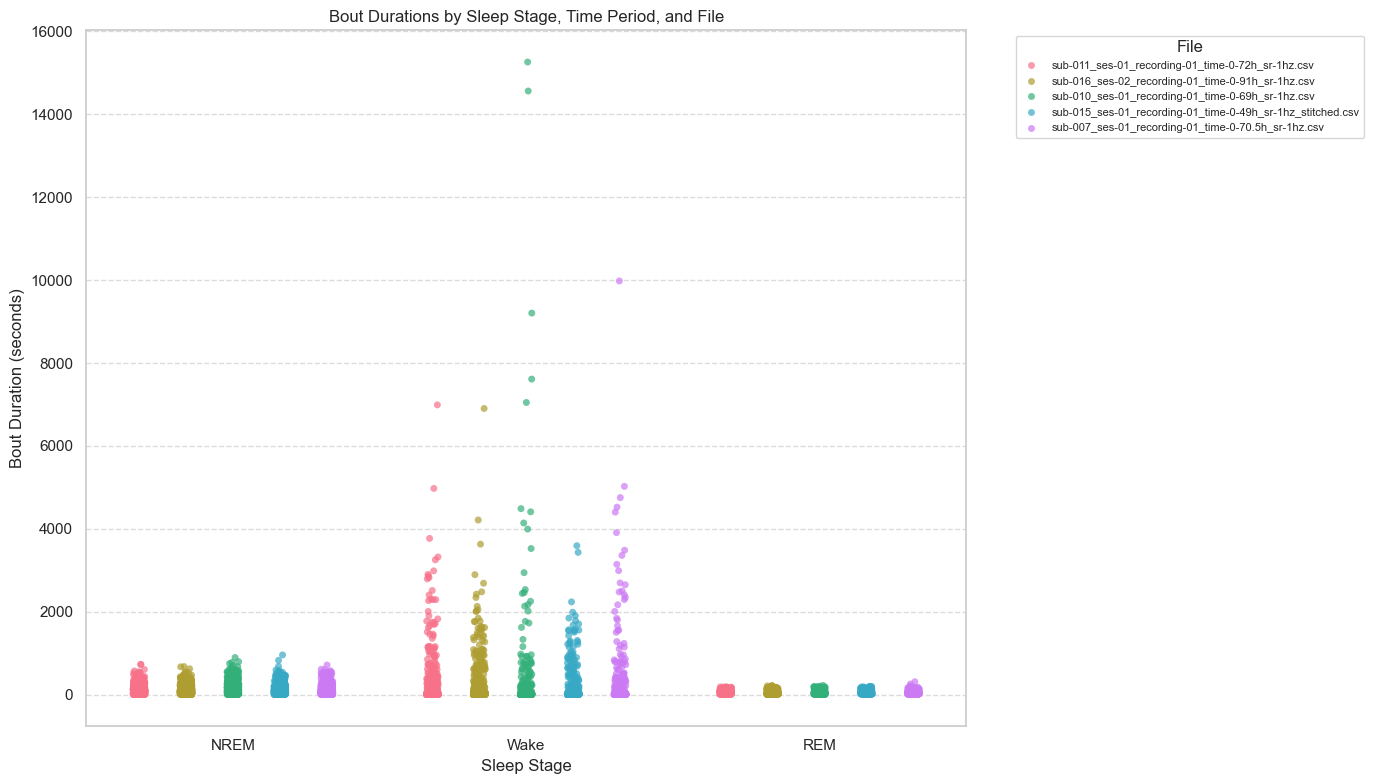

In [86]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns

# List of CSV file paths
csv_files = glob.glob('/Volumes/harris/volkan/sleep_profile/downsample_auto_score/bout_duration/*.csv')

# List to store all bout durations from all files
all_bout_durations = []

for file in csv_files:
    # Load the CSV file
    df = pd.read_csv(file)
    
    # Convert Timestamp column to datetime format
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Round the numbers in the sleepStage column to the nearest integer
    df['sleepStage'] = df['sleepStage'].round().astype(int)
    
    # Create a new column to track changes in sleep stage
    df['sleepStageChange'] = df['sleepStage'] != df['sleepStage'].shift()
    
    # Create a cumulative sum of changes to identify continuous instances
    df['boutId'] = df['sleepStageChange'].cumsum()
    
    # Determine the time period (light or dark) for each row
    def get_time_period(row):
        hour = row['Timestamp'].hour
        if 9 <= hour < 21:
            return 'Light'
        else:
            return 'Dark'
    
    df['timePeriod'] = df.apply(get_time_period, axis=1)
    
    # Group by boutId and sleepStage, then calculate the count of rows for each bout
    bout_durations = df.groupby(['boutId', 'sleepStage', 'timePeriod']).size().reset_index(name='boutDuration')
    
    # Map sleep stages to their corresponding names
    sleep_stage_map = {1: 'Wake', 2: 'NREM', 3: 'REM'}
    bout_durations['sleepStage'] = bout_durations['sleepStage'].map(sleep_stage_map)
    
    # Add a column for the filename to distinguish data points from different files
    bout_durations['File'] = file.split('/')[-1]
    
    # Append to the master list
    all_bout_durations.append(bout_durations)

# Concatenate all bout durations into a single DataFrame
all_bout_durations_df = pd.concat(all_bout_durations, ignore_index=True)

# Assign unique colors to each file
unique_files = all_bout_durations_df['File'].unique()
file_palette = sns.color_palette("husl", len(unique_files))
file_color_map = {file: color for file, color in zip(unique_files, file_palette)}

# Plot using seaborn stripplot
plt.figure(figsize=(14, 8))
sns.stripplot(
    data=all_bout_durations_df,
    x="sleepStage",
    y="boutDuration",
    hue="File",
    dodge=True,
    jitter=True,
    palette=file_color_map,
    alpha=0.7
)

# Customize the plot
plt.ylabel('Bout Duration (seconds)')
plt.xlabel('Sleep Stage')
plt.title('Bout Durations by Sleep Stage, Time Period, and File')
plt.legend(title="File", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()


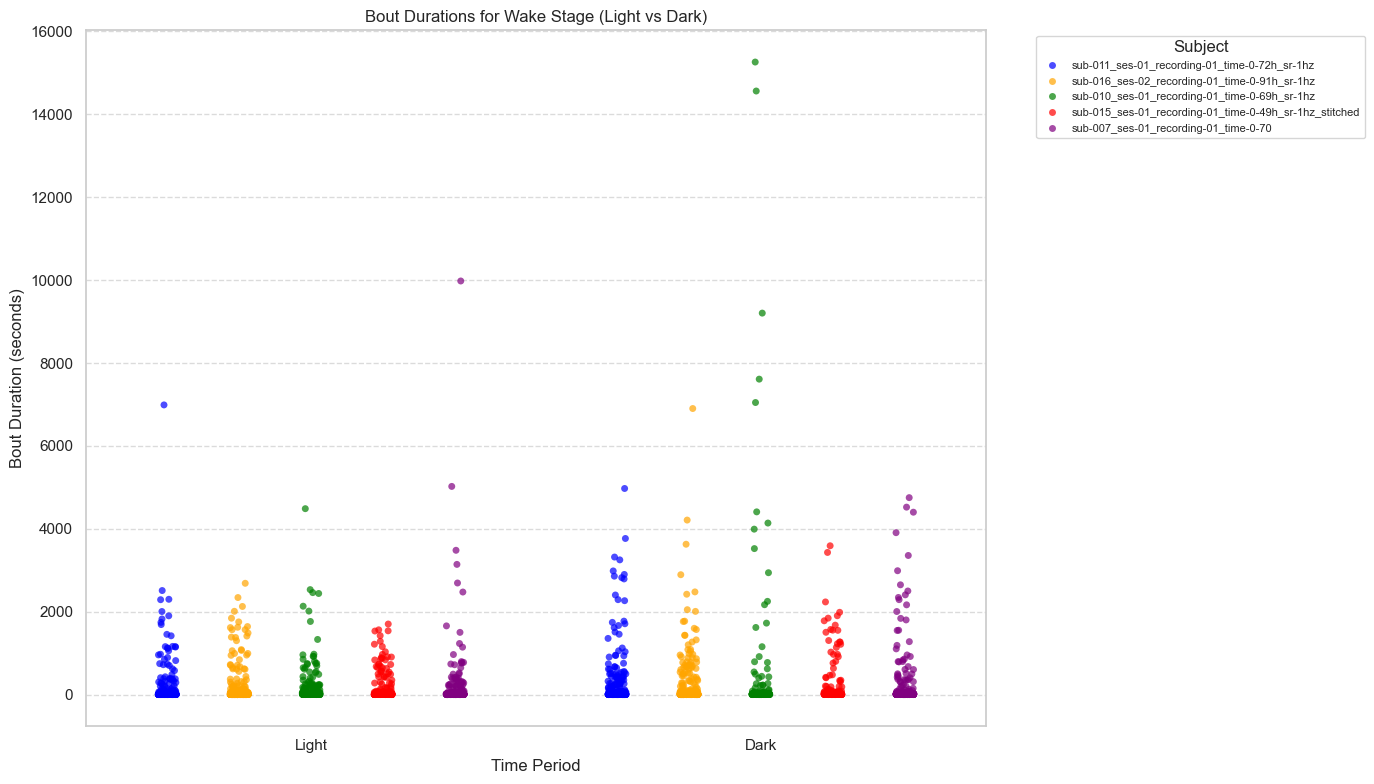

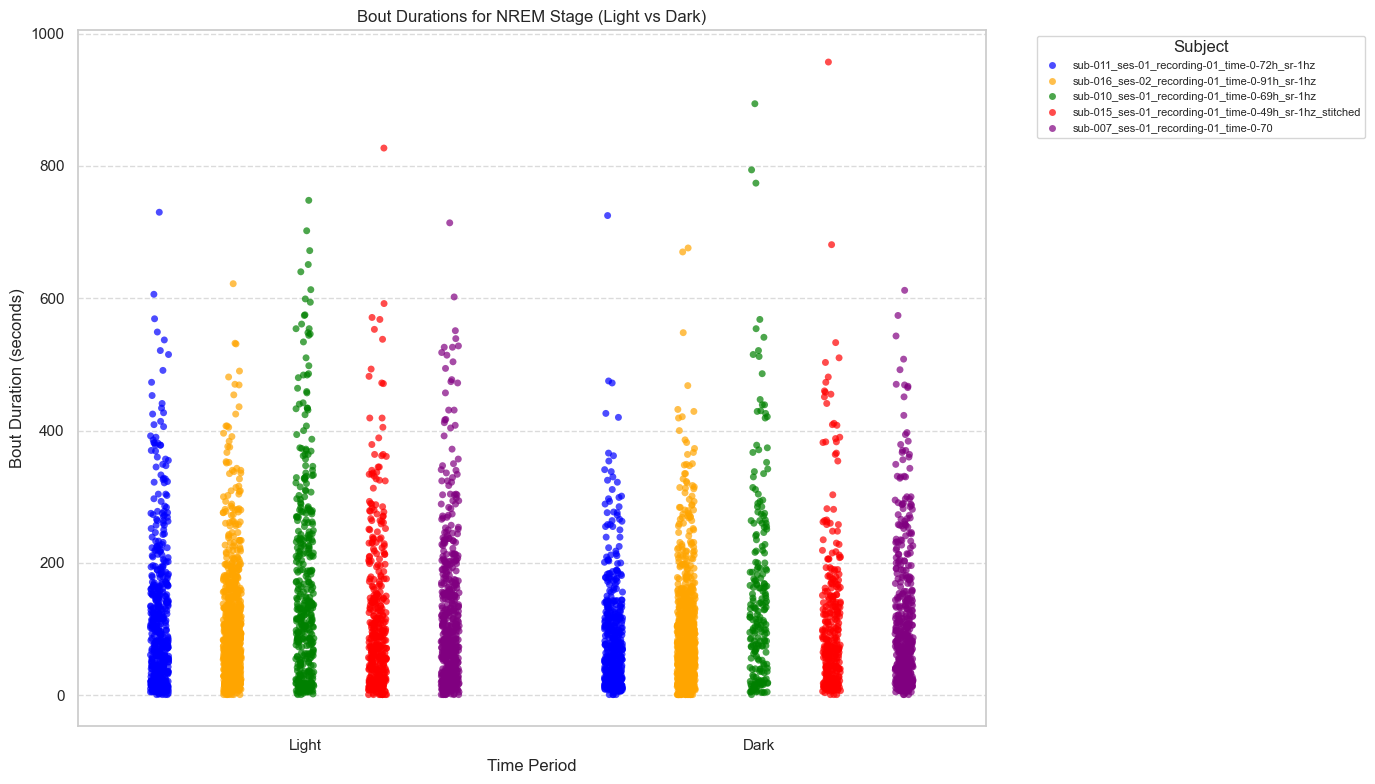

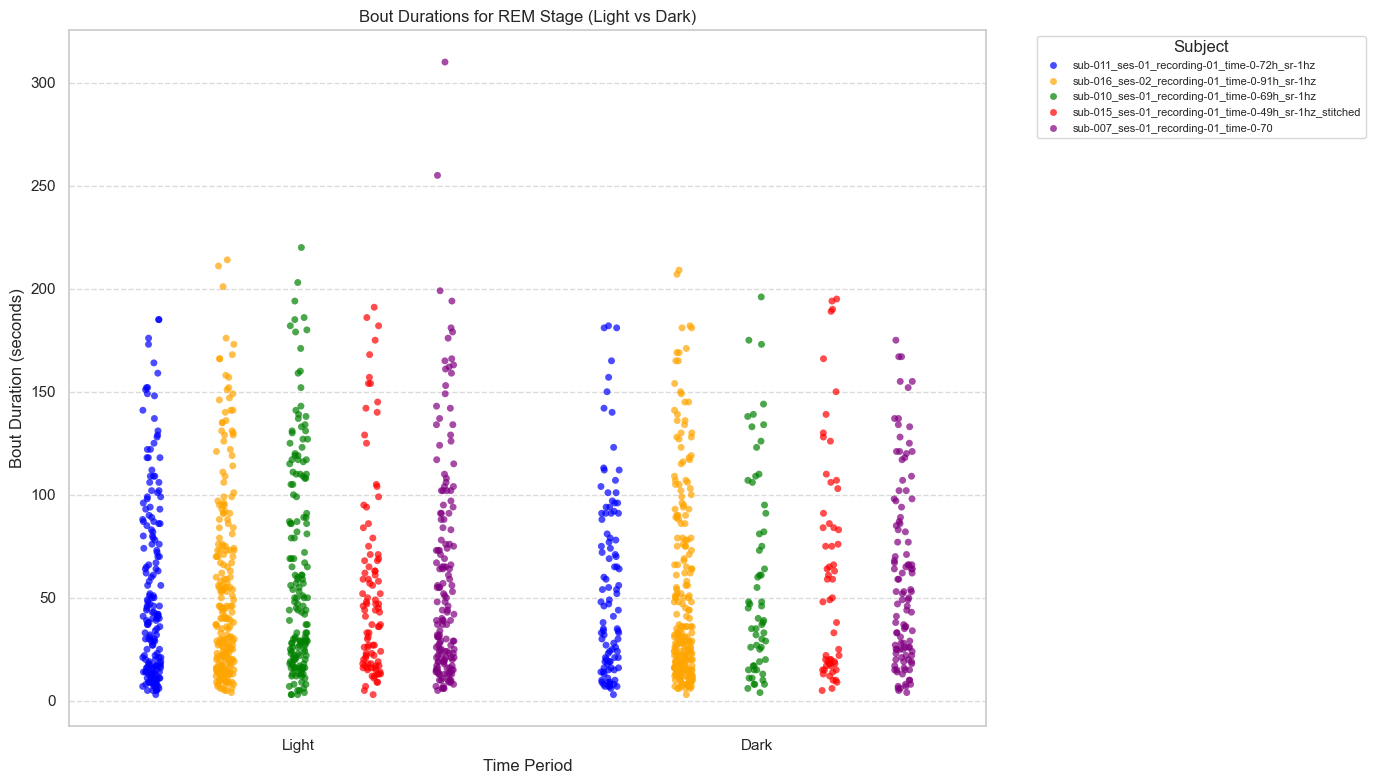

In [98]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns

# List of CSV file paths
csv_files = glob.glob('/Volumes/harris/volkan/sleep_profile/downsample_auto_score/bout_duration/*.csv')

# List to store all bout durations from all files
all_bout_durations = []

for file in csv_files:
    # Load the CSV file
    df = pd.read_csv(file)
    
    # Convert Timestamp column to datetime format
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Round the numbers in the sleepStage column to the nearest integer
    df['sleepStage'] = df['sleepStage'].round().astype(int)
    
    # Create a new column to track changes in sleep stage
    df['sleepStageChange'] = df['sleepStage'] != df['sleepStage'].shift()
    
    # Create a cumulative sum of changes to identify continuous instances
    df['boutId'] = df['sleepStageChange'].cumsum()
    
    # Determine the time period (light or dark) for each row
    def get_time_period(row):
        hour = row['Timestamp'].hour
        if 9 <= hour < 21:
            return 'Light'
        else:
            return 'Dark'
    
    df['timePeriod'] = df.apply(get_time_period, axis=1)
    
    # Group by boutId and sleepStage, then calculate the count of rows for each bout
    bout_durations = df.groupby(['boutId', 'sleepStage', 'timePeriod']).size().reset_index(name='boutDuration')
    
    # Map sleep stages to their corresponding names
    sleep_stage_map = {1: 'Wake', 2: 'NREM', 3: 'REM'}
    bout_durations['sleepStage'] = bout_durations['sleepStage'].map(sleep_stage_map)
    
    # Add a column for the filename to distinguish data points from different files
    subject_name = file.split('/')[-1].split('.')[0]  # Extract subject name from filename (assuming subject name is in the file name)
    bout_durations['Subject'] = subject_name
    
    # Append to the master list
    all_bout_durations.append(bout_durations)

# Concatenate all bout durations into a single DataFrame
all_bout_durations_df = pd.concat(all_bout_durations, ignore_index=True)

# Assign unique colors to each subject
unique_subjects = all_bout_durations_df['Subject'].unique()
subject_palette = sns.color_palette("husl", len(unique_subjects))
subject_color_map = {subject: color for subject, color in zip(unique_subjects, subject_palette)}

# Prompt for colors if necessary
# For example, ask the user to define colors for each subject
for subject in unique_subjects:
    color = input(f"Enter a color for subject '{subject}': ")
    if color:
        subject_color_map[subject] = color

# Create separate plots for Wake, NREM, and REM
for sleep_stage in ['Wake', 'NREM', 'REM']:
    # Filter the data for the current sleep stage
    stage_data = all_bout_durations_df[all_bout_durations_df['sleepStage'] == sleep_stage]
    
    # Plot
    plt.figure(figsize=(14, 8))
    sns.stripplot(
        data=stage_data,
        x="timePeriod",  # Light vs Dark comparison
        y="boutDuration",
        hue="Subject",  # Now using Subject for hue
        dodge=True,
        jitter=True,
        palette=subject_color_map,  # Use subject-specific color map
        alpha=0.7
    )
    
    # Customize the plot
    plt.ylabel('Bout Duration (seconds)')
    plt.xlabel('Time Period')
    plt.title(f'Bout Durations for {sleep_stage} Stage (Light vs Dark)')
    plt.legend(title="Subject", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show plot
    plt.tight_layout()
    plt.show()


Results for sub-011_ses-01_recording-01_time-0-72h_sr-1hz.csv:
                             mean        sem
timePeriod sleepStage                       
Dark       NREM         92.184783   4.054887
           REM          63.101124   4.694607
           Wake        325.904762  47.785474
Light      NREM        127.207661   5.132754
           REM          60.310559   3.508699
           Wake        226.229787  40.387723
                  mean        sem
timePeriod                       
Dark        162.483146  15.700429
Light       141.220852  11.179577

Results for sub-016_ses-02_recording-01_time-0-91h_sr-1hz.csv:
                             mean        sem
timePeriod sleepStage                       
Dark       NREM         97.228535   3.037708
           REM          55.502326   3.219304
           Wake        187.724638  27.794560
Light      NREM        105.191358   3.156178
           REM          59.524510   3.252364
           Wake        131.439732  17.781958
                 

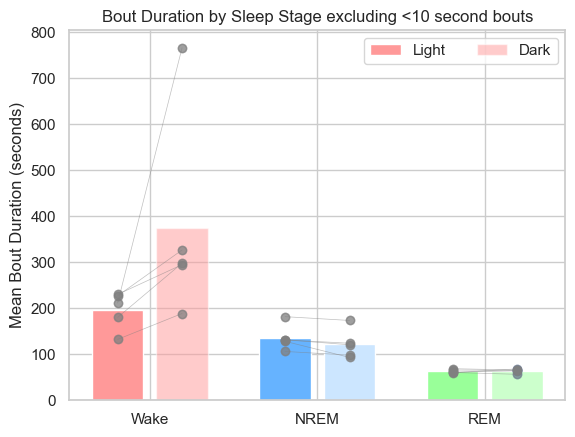

In [87]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# List of CSV file paths
csv_files = glob.glob('/Volumes/harris/volkan/sleep_profile/downsample_auto_score/bout_duration/*.csv')

# Dictionary to store results
results = {}

for file in csv_files:
    # Load the CSV file
    df = pd.read_csv(file)
    
    # Convert Timestamp column to datetime format
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Round the numbers in the sleepStage column to the nearest integer
    df['sleepStage'] = df['sleepStage'].round().astype(int)
    
    # Create a new column to track changes in sleep stage
    df['sleepStageChange'] = df['sleepStage'] != df['sleepStage'].shift()
    
    # Create a cumulative sum of changes to identify continuous instances
    df['boutId'] = df['sleepStageChange'].cumsum()
    
    # Determine the time period (light or dark) for each row
    def get_time_period(row):
        hour = row['Timestamp'].hour
        if 9 <= hour < 21:
            return 'Light'
        else:
            return 'Dark'
    
    df['timePeriod'] = df.apply(get_time_period, axis=1)
    
    # Group by boutId and sleepStage, then calculate the count of rows for each bout
    bout_durations = df.groupby(['boutId', 'sleepStage']).size().reset_index(name='boutDuration')

    # Filter out bout durations less than 10 seconds
    bout_durations = bout_durations[bout_durations['boutDuration'] >= 10]
    
    # Map sleep stages to their corresponding names (optional)
    sleep_stage_map = {1: 'Wake', 2: 'NREM', 3: 'REM'}
    bout_durations['sleepStage'] = bout_durations['sleepStage'].map(sleep_stage_map)
    
    # Determine the time period for each bout based on the majority time
    bout_time_periods = df.groupby('boutId')['timePeriod'].apply(lambda x: x.value_counts().index[0]).reset_index()
    
    # Merge the bout durations with the time periods
    bout_durations = pd.merge(bout_durations, bout_time_periods, on='boutId')
    
    # Group by timePeriod and sleepStage, then calculate the mean and standard error of boutDuration
    light_dark_avg_duration_stages = bout_durations.groupby(['timePeriod', 'sleepStage'])['boutDuration'].agg(['mean', 'sem'])
    light_dark_avg_duration_all_stage = bout_durations.groupby(['timePeriod'])['boutDuration'].agg(['mean', 'sem'])
    
    # Store results in dictionary
    filename = file.split('/')[-1]
    results[filename] = {
        'bout_durations': bout_durations,
        'light_dark_avg_duration_stages': light_dark_avg_duration_stages,
        'light_dark_avg_duration_all_stage': light_dark_avg_duration_all_stage
    }

# Print results
for filename, result in results.items():
    print(f"Results for {filename}:")
    print(result['light_dark_avg_duration_stages'])
    print(result['light_dark_avg_duration_all_stage'])
    print()

# Create lists to store average bout durations for Wake, NREM, and REM
wake_avg_durations = []
nrem_avg_durations = []
rem_avg_durations = []

# Dictionary to store individual subject data
subject_data = {'Wake': [], 'NREM': [], 'REM': []}

for filename, result in results.items():
    wake_avg_duration = result['light_dark_avg_duration_stages'].loc[('Light', 'Wake'), 'mean']
    nrem_avg_duration = result['light_dark_avg_duration_stages'].loc[('Light', 'NREM'), 'mean']
    rem_avg_duration = result['light_dark_avg_duration_stages'].loc[('Light', 'REM'), 'mean']
    
    wake_avg_durations.append(wake_avg_duration)
    nrem_avg_durations.append(nrem_avg_duration)
    rem_avg_durations.append(rem_avg_duration)
    
    # Store individual subject data
    subject_data['Wake'].append(result['light_dark_avg_duration_stages'].loc[('Light', 'Wake'), 'mean'])
    subject_data['NREM'].append(result['light_dark_avg_duration_stages'].loc[('Light', 'NREM'), 'mean'])
    subject_data['REM'].append(result['light_dark_avg_duration_stages'].loc[('Light', 'REM'), 'mean'])

# Calculate mean and standard error for bars
wake_light_mean = np.mean([result['light_dark_avg_duration_stages'].loc[('Light', 'Wake'), 'mean'] for result in results.values()])
wake_light_sem = stats.sem([result['light_dark_avg_duration_stages'].loc[('Light', 'Wake'), 'mean'] for result in results.values()])
wake_dark_mean = np.mean([result['light_dark_avg_duration_stages'].loc[('Dark', 'Wake'), 'mean'] for result in results.values()])
wake_dark_sem = stats.sem([result['light_dark_avg_duration_stages'].loc[('Dark', 'Wake'), 'mean'] for result in results.values()])

nrem_light_mean = np.mean([result['light_dark_avg_duration_stages'].loc[('Light', 'NREM'), 'mean'] for result in results.values()])
nrem_light_sem = stats.sem([result['light_dark_avg_duration_stages'].loc[('Light', 'NREM'), 'mean'] for result in results.values()])
nrem_dark_mean = np.mean([result['light_dark_avg_duration_stages'].loc[('Dark', 'NREM'), 'mean'] for result in results.values()])
nrem_dark_sem = stats.sem([result['light_dark_avg_duration_stages'].loc[('Dark', 'NREM'), 'mean'] for result in results.values()])

rem_light_mean = np.mean([result['light_dark_avg_duration_stages'].loc[('Light', 'REM'), 'mean'] for result in results.values()])
rem_light_sem = stats.sem([result['light_dark_avg_duration_stages'].loc[('Light', 'REM'), 'mean'] for result in results.values()])
rem_dark_mean = np.mean([result['light_dark_avg_duration_stages'].loc[('Dark', 'REM'), 'mean'] for result in results.values()])
rem_dark_sem = stats.sem([result['light_dark_avg_duration_stages'].loc[('Dark', 'REM'), 'mean'] for result in results.values()])

# Create bar plot
bar_width = 0.2
bar_spacing = 0.25  # Reduced spacing

wake_light_pos = 0
wake_dark_pos = wake_light_pos + bar_spacing
nrem_light_pos = wake_dark_pos + bar_width + 0.2  # Increased spacing between groups
nrem_dark_pos = nrem_light_pos + bar_spacing
rem_light_pos = nrem_dark_pos + bar_width + 0.2  # Increased spacing between groups
rem_dark_pos = rem_light_pos + bar_spacing

plt.bar(wake_light_pos, wake_light_mean, bar_width, capsize=5, color='#ff9999', label='Light')
plt.bar(wake_dark_pos, wake_dark_mean, bar_width, capsize=5, color='#ff9999', label='Dark', alpha=0.5)
plt.bar(nrem_light_pos, nrem_light_mean, bar_width,capsize=5, color='#66b3ff', label=None)
plt.bar(nrem_dark_pos, nrem_dark_mean, bar_width, capsize=5, color='#cce6ff', label=None)
plt.bar(rem_light_pos, rem_light_mean, bar_width, capsize=5, color='#99ff99', label=None)
plt.bar(rem_dark_pos, rem_dark_mean, bar_width, capsize=5, color='#ccffcc', label=None)

# Add scatter plot for individual subjects
wake_light_data = [result['light_dark_avg_duration_stages'].loc[('Light', 'Wake'), 'mean'] for result in results.values()]
wake_dark_data = [result['light_dark_avg_duration_stages'].loc[('Dark', 'Wake'), 'mean'] for result in results.values()]
nrem_light_data = [result['light_dark_avg_duration_stages'].loc[('Light', 'NREM'), 'mean'] for result in results.values()]
nrem_dark_data = [result['light_dark_avg_duration_stages'].loc[('Dark', 'NREM'), 'mean'] for result in results.values()]
rem_light_data = [result['light_dark_avg_duration_stages'].loc[('Light', 'REM'), 'mean'] for result in results.values()]
rem_dark_data = [result['light_dark_avg_duration_stages'].loc[('Dark', 'REM'), 'mean'] for result in results.values()]

plt.scatter(np.repeat(wake_light_pos, len(wake_light_data)), wake_light_data, color='gray', alpha=0.5)
plt.scatter(np.repeat(wake_dark_pos, len(wake_dark_data)), wake_dark_data, color='gray',alpha=0.5)
plt.scatter(np.repeat(nrem_light_pos, len(nrem_light_data)), nrem_light_data, color='gray',alpha=0.5)
plt.scatter(np.repeat(nrem_dark_pos, len(nrem_dark_data)), nrem_dark_data, color='gray',alpha=0.5)
plt.scatter(np.repeat(rem_light_pos, len(rem_light_data)), rem_light_data, color='gray',alpha=0.5)
plt.scatter(np.repeat(rem_dark_pos, len(rem_dark_data)), rem_dark_data, alpha=0.5)

# Add lines connecting individual subject means
for i in range(len(wake_light_data)):
    wake_light_x = wake_light_pos
    wake_dark_x = wake_dark_pos
    nrem_light_x = nrem_light_pos
    nrem_dark_x = nrem_dark_pos
    rem_light_x = rem_light_pos
    rem_dark_x = rem_dark_pos
    
    wake_light_y = wake_light_data[i]
    wake_dark_y = wake_dark_data[i]
    nrem_light_y = nrem_light_data[i]
    nrem_dark_y = nrem_dark_data[i]
    rem_light_y = rem_light_data[i]
    rem_dark_y = rem_dark_data[i]
    
    plt.plot([wake_light_x, wake_dark_x], [wake_light_y, wake_dark_y], 'o-', linewidth=0.5, color='gray', alpha=0.5)
    plt.plot([nrem_light_x, nrem_dark_x], [nrem_light_y, nrem_dark_y], 'o-', linewidth=0.5, color='gray', alpha=0.5)
    plt.plot([rem_light_x, rem_dark_x], [rem_light_y, rem_dark_y], 'o-', linewidth=0.5, color='gray', alpha=0.5)

# Set x-axis ticks and labels
plt.xticks([(wake_light_pos + wake_dark_pos) / 2, (nrem_light_pos + nrem_dark_pos) / 2, (rem_light_pos + rem_dark_pos) / 2], 
           ['Wake', 'NREM', 'REM'])
plt.ylabel('Mean Bout Duration (seconds)')
plt.title('Bout Duration by Sleep Stage excluding <10 second bouts')

# Add legend
plt.legend(ncol=2)

# Show plot
plt.show()


Results for sub-016_ses-02_recording-01_time-0-91h_sr-1hz_consolidated.csv:
                                         mean        sem
timePeriod sleepStageConsolidated                       
Dark       NREM                    248.563863  12.689057
           REM                      55.502326   3.219304
           Wake                    333.434211  52.674467
Light      NREM                    295.657895  13.698893
           REM                      59.524510   3.252364
           Wake                    237.319328  33.783581
                  mean        sem
timePeriod                       
Dark        219.561518  17.058635
Light       212.473190  12.663412

Results for sub-007_ses-01_recording-01_time-0-70.5h_sr-1hz_consolidated.csv:
                                         mean         sem
timePeriod sleepStageConsolidated                        
Dark       NREM                    360.860000   24.219766
           REM                      63.862745    4.285960
           Wake      

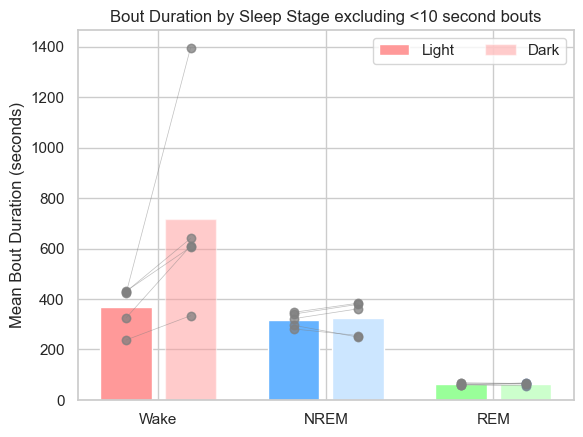

In [40]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# List of CSV file paths
csv_files = glob.glob('/Volumes/harris/volkan/sleep_profile/downsample_auto_score/bout_duration_consolidated/*.csv')

# Dictionary to store results
results = {}

for file in csv_files:
    # Load the CSV file
    df = pd.read_csv(file)
    
    # Convert Timestamp column to datetime format
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Round the numbers in the sleepStageConsolidated column to the nearest integer
    df['sleepStageConsolidated'] = df['sleepStageConsolidated'].round().astype(int)
    
    # Create a new column to track changes in sleep stage
    df['sleepStageConsolidatedChange'] = df['sleepStageConsolidated'] != df['sleepStageConsolidated'].shift()
    
    # Create a cumulative sum of changes to identify continuous instances
    df['boutId'] = df['sleepStageConsolidatedChange'].cumsum()
    
    # Determine the time period (light or dark) for each row
    def get_time_period(row):
        hour = row['Timestamp'].hour
        if 9 <= hour < 21:
            return 'Light'
        else:
            return 'Dark'
    
    df['timePeriod'] = df.apply(get_time_period, axis=1)
    
    # Group by boutId and sleepStageConsolidated, then calculate the count of rows for each bout
    bout_durations = df.groupby(['boutId', 'sleepStageConsolidated']).size().reset_index(name='boutDuration')

    # Filter out bout durations less than 10 seconds
    bout_durations = bout_durations[bout_durations['boutDuration'] >= 10]
    
    # Map sleep stages to their corresponding names (optional)
    sleep_stage_map = {1: 'Wake', 2: 'NREM', 3: 'REM'}
    bout_durations['sleepStageConsolidated'] = bout_durations['sleepStageConsolidated'].map(sleep_stage_map)
    
    # Determine the time period for each bout based on the majority time
    bout_time_periods = df.groupby('boutId')['timePeriod'].apply(lambda x: x.value_counts().index[0]).reset_index()
    
    # Merge the bout durations with the time periods
    bout_durations = pd.merge(bout_durations, bout_time_periods, on='boutId')
    
    # Group by timePeriod and sleepStageConsolidated, then calculate the mean and standard error of boutDuration
    light_dark_avg_duration_stages = bout_durations.groupby(['timePeriod', 'sleepStageConsolidated'])['boutDuration'].agg(['mean', 'sem'])
    light_dark_avg_duration_all_stage = bout_durations.groupby(['timePeriod'])['boutDuration'].agg(['mean', 'sem'])
    
    # Store results in dictionary
    filename = file.split('/')[-1]
    results[filename] = {
        'bout_durations': bout_durations,
        'light_dark_avg_duration_stages': light_dark_avg_duration_stages,
        'light_dark_avg_duration_all_stage': light_dark_avg_duration_all_stage
    }

# Print results
for filename, result in results.items():
    print(f"Results for {filename}:")
    print(result['light_dark_avg_duration_stages'])
    print(result['light_dark_avg_duration_all_stage'])
    print()

# Create lists to store average bout durations for Wake, NREM, and REM
wake_avg_durations = []
nrem_avg_durations = []
rem_avg_durations = []

# Dictionary to store individual subject data
subject_data = {'Wake': [], 'NREM': [], 'REM': []}

for filename, result in results.items():
    wake_avg_duration = result['light_dark_avg_duration_stages'].loc[('Light', 'Wake'), 'mean']
    nrem_avg_duration = result['light_dark_avg_duration_stages'].loc[('Light', 'NREM'), 'mean']
    rem_avg_duration = result['light_dark_avg_duration_stages'].loc[('Light', 'REM'), 'mean']
    
    wake_avg_durations.append(wake_avg_duration)
    nrem_avg_durations.append(nrem_avg_duration)
    rem_avg_durations.append(rem_avg_duration)
    
    # Store individual subject data
    subject_data['Wake'].append(result['light_dark_avg_duration_stages'].loc[('Light', 'Wake'), 'mean'])
    subject_data['NREM'].append(result['light_dark_avg_duration_stages'].loc[('Light', 'NREM'), 'mean'])
    subject_data['REM'].append(result['light_dark_avg_duration_stages'].loc[('Light', 'REM'), 'mean'])

# Calculate mean and standard error for bars
wake_light_mean = np.mean([result['light_dark_avg_duration_stages'].loc[('Light', 'Wake'), 'mean'] for result in results.values()])
wake_light_sem = stats.sem([result['light_dark_avg_duration_stages'].loc[('Light', 'Wake'), 'mean'] for result in results.values()])
wake_dark_mean = np.mean([result['light_dark_avg_duration_stages'].loc[('Dark', 'Wake'), 'mean'] for result in results.values()])
wake_dark_sem = stats.sem([result['light_dark_avg_duration_stages'].loc[('Dark', 'Wake'), 'mean'] for result in results.values()])

nrem_light_mean = np.mean([result['light_dark_avg_duration_stages'].loc[('Light', 'NREM'), 'mean'] for result in results.values()])
nrem_light_sem = stats.sem([result['light_dark_avg_duration_stages'].loc[('Light', 'NREM'), 'mean'] for result in results.values()])
nrem_dark_mean = np.mean([result['light_dark_avg_duration_stages'].loc[('Dark', 'NREM'), 'mean'] for result in results.values()])
nrem_dark_sem = stats.sem([result['light_dark_avg_duration_stages'].loc[('Dark', 'NREM'), 'mean'] for result in results.values()])

rem_light_mean = np.mean([result['light_dark_avg_duration_stages'].loc[('Light', 'REM'), 'mean'] for result in results.values()])
rem_light_sem = stats.sem([result['light_dark_avg_duration_stages'].loc[('Light', 'REM'), 'mean'] for result in results.values()])
rem_dark_mean = np.mean([result['light_dark_avg_duration_stages'].loc[('Dark', 'REM'), 'mean'] for result in results.values()])
rem_dark_sem = stats.sem([result['light_dark_avg_duration_stages'].loc[('Dark', 'REM'), 'mean'] for result in results.values()])

# Create bar plot
bar_width = 0.2
bar_spacing = 0.25  # Reduced spacing

wake_light_pos = 0
wake_dark_pos = wake_light_pos + bar_spacing
nrem_light_pos = wake_dark_pos + bar_width + 0.2  # Increased spacing between groups
nrem_dark_pos = nrem_light_pos + bar_spacing
rem_light_pos = nrem_dark_pos + bar_width + 0.2  # Increased spacing between groups
rem_dark_pos = rem_light_pos + bar_spacing

plt.bar(wake_light_pos, wake_light_mean, bar_width, capsize=5, color='#ff9999', label='Light')
plt.bar(wake_dark_pos, wake_dark_mean, bar_width, capsize=5, color='#ff9999', label='Dark', alpha=0.5)
plt.bar(nrem_light_pos, nrem_light_mean, bar_width,capsize=5, color='#66b3ff', label=None)
plt.bar(nrem_dark_pos, nrem_dark_mean, bar_width, capsize=5, color='#cce6ff', label=None)
plt.bar(rem_light_pos, rem_light_mean, bar_width, capsize=5, color='#99ff99', label=None)
plt.bar(rem_dark_pos, rem_dark_mean, bar_width, capsize=5, color='#ccffcc', label=None)

# Add scatter plot for individual subjects
wake_light_data = [result['light_dark_avg_duration_stages'].loc[('Light', 'Wake'), 'mean'] for result in results.values()]
wake_dark_data = [result['light_dark_avg_duration_stages'].loc[('Dark', 'Wake'), 'mean'] for result in results.values()]
nrem_light_data = [result['light_dark_avg_duration_stages'].loc[('Light', 'NREM'), 'mean'] for result in results.values()]
nrem_dark_data = [result['light_dark_avg_duration_stages'].loc[('Dark', 'NREM'), 'mean'] for result in results.values()]
rem_light_data = [result['light_dark_avg_duration_stages'].loc[('Light', 'REM'), 'mean'] for result in results.values()]
rem_dark_data = [result['light_dark_avg_duration_stages'].loc[('Dark', 'REM'), 'mean'] for result in results.values()]

plt.scatter(np.repeat(wake_light_pos, len(wake_light_data)), wake_light_data, color='gray', alpha=0.5)
plt.scatter(np.repeat(wake_dark_pos, len(wake_dark_data)), wake_dark_data, color='gray',alpha=0.5)
plt.scatter(np.repeat(nrem_light_pos, len(nrem_light_data)), nrem_light_data, color='gray',alpha=0.5)
plt.scatter(np.repeat(nrem_dark_pos, len(nrem_dark_data)), nrem_dark_data, color='gray',alpha=0.5)
plt.scatter(np.repeat(rem_light_pos, len(rem_light_data)), rem_light_data, color='gray',alpha=0.5)
plt.scatter(np.repeat(rem_dark_pos, len(rem_dark_data)), rem_dark_data, alpha=0.5)

# Add lines connecting individual subject means
for i in range(len(wake_light_data)):
    wake_light_x = wake_light_pos
    wake_dark_x = wake_dark_pos
    nrem_light_x = nrem_light_pos
    nrem_dark_x = nrem_dark_pos
    rem_light_x = rem_light_pos
    rem_dark_x = rem_dark_pos
    
    wake_light_y = wake_light_data[i]
    wake_dark_y = wake_dark_data[i]
    nrem_light_y = nrem_light_data[i]
    nrem_dark_y = nrem_dark_data[i]
    rem_light_y = rem_light_data[i]
    rem_dark_y = rem_dark_data[i]
    
    plt.plot([wake_light_x, wake_dark_x], [wake_light_y, wake_dark_y], 'o-', linewidth=0.5, color='gray', alpha=0.5)
    plt.plot([nrem_light_x, nrem_dark_x], [nrem_light_y, nrem_dark_y], 'o-', linewidth=0.5, color='gray', alpha=0.5)
    plt.plot([rem_light_x, rem_dark_x], [rem_light_y, rem_dark_y], 'o-', linewidth=0.5, color='gray', alpha=0.5)

# Set x-axis ticks and labels
plt.xticks([(wake_light_pos + wake_dark_pos) / 2, (nrem_light_pos + nrem_dark_pos) / 2, (rem_light_pos + rem_dark_pos) / 2], 
           ['Wake', 'NREM', 'REM'])
plt.ylabel('Mean Bout Duration (seconds)')
plt.title('Bout Duration by Sleep Stage excluding <10 second bouts')

# Add legend
plt.legend(ncol=2)

# Show plot
plt.show()


Results for sub-016_ses-02_recording-01_time-0-91h_sr-1hz_consolidated.csv:
                                         mean        sem
timePeriod sleepStageConsolidated                       
Dark       NREM                    242.705167  12.548483
           REM                      51.956897   3.096213
           Wake                    288.837121  46.001518
Light      NREM                    293.774510  13.674004
           REM                      55.727273   3.151566
           Wake                    205.427536  29.518809
                  mean        sem
timePeriod                       
Dark        203.826667  15.915246
Light       198.071072  11.924185

Results for sub-007_ses-01_recording-01_time-0-70.5h_sr-1hz_consolidated.csv:
                                         mean        sem
timePeriod sleepStageConsolidated                       
Dark       NREM                    358.523179  24.172056
           REM                      59.681818   4.222461
           Wake          

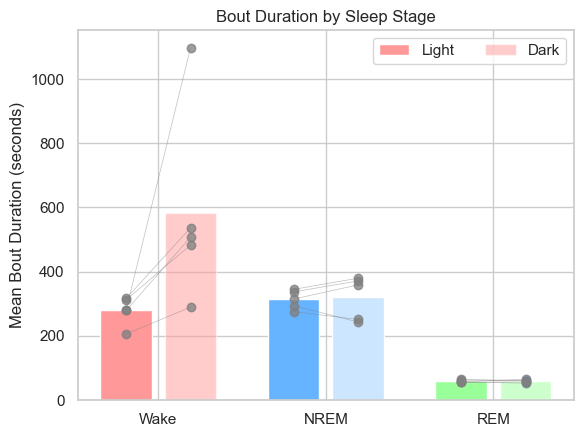

In [41]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# List of CSV file paths
csv_files = glob.glob('/Volumes/harris/volkan/sleep_profile/downsample_auto_score/bout_duration_consolidated/*.csv')

# Dictionary to store results
results = {}

for file in csv_files:
    # Load the CSV file
    df = pd.read_csv(file)
    
    # Convert Timestamp column to datetime format
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Round the numbers in the sleepStageConsolidated column to the nearest integer
    df['sleepStageConsolidated'] = df['sleepStageConsolidated'].round().astype(int)
    
    # Create a new column to track changes in sleep stage
    df['sleepStageConsolidatedChange'] = df['sleepStageConsolidated'] != df['sleepStageConsolidated'].shift()
    
    # Create a cumulative sum of changes to identify continuous instances
    df['boutId'] = df['sleepStageConsolidatedChange'].cumsum()
    
    # Determine the time period (light or dark) for each row
    def get_time_period(row):
        hour = row['Timestamp'].hour
        if 9 <= hour < 21:
            return 'Light'
        else:
            return 'Dark'
    
    df['timePeriod'] = df.apply(get_time_period, axis=1)
    
    # Group by boutId and sleepStageConsolidated, then calculate the count of rows for each bout
    bout_durations = df.groupby(['boutId', 'sleepStageConsolidated']).size().reset_index(name='boutDuration')
    
    # Map sleep stages to their corresponding names (optional)
    sleep_stage_map = {1: 'Wake', 2: 'NREM', 3: 'REM'}
    bout_durations['sleepStageConsolidated'] = bout_durations['sleepStageConsolidated'].map(sleep_stage_map)
    
    # Determine the time period for each bout based on the majority time
    bout_time_periods = df.groupby('boutId')['timePeriod'].apply(lambda x: x.value_counts().index[0]).reset_index()
    
    # Merge the bout durations with the time periods
    bout_durations = pd.merge(bout_durations, bout_time_periods, on='boutId')
    
    # Group by timePeriod and sleepStageConsolidated, then calculate the mean and standard error of boutDuration
    light_dark_avg_duration_stages = bout_durations.groupby(['timePeriod', 'sleepStageConsolidated'])['boutDuration'].agg(['mean', 'sem'])
    light_dark_avg_duration_all_stage = bout_durations.groupby(['timePeriod'])['boutDuration'].agg(['mean', 'sem'])
    
    # Store results in dictionary
    filename = file.split('/')[-1]
    results[filename] = {
        'bout_durations': bout_durations,
        'light_dark_avg_duration_stages': light_dark_avg_duration_stages,
        'light_dark_avg_duration_all_stage': light_dark_avg_duration_all_stage
    }

# Print results
for filename, result in results.items():
    print(f"Results for {filename}:")
    print(result['light_dark_avg_duration_stages'])
    print(result['light_dark_avg_duration_all_stage'])
    print()

# Create lists to store average bout durations for Wake, NREM, and REM
wake_avg_durations = []
nrem_avg_durations = []
rem_avg_durations = []

# Dictionary to store individual subject data
subject_data = {'Wake': [], 'NREM': [], 'REM': []}

for filename, result in results.items():
    wake_avg_duration = result['light_dark_avg_duration_stages'].loc[('Light', 'Wake'), 'mean']
    nrem_avg_duration = result['light_dark_avg_duration_stages'].loc[('Light', 'NREM'), 'mean']
    rem_avg_duration = result['light_dark_avg_duration_stages'].loc[('Light', 'REM'), 'mean']
    
    wake_avg_durations.append(wake_avg_duration)
    nrem_avg_durations.append(nrem_avg_duration)
    rem_avg_durations.append(rem_avg_duration)
    
    # Store individual subject data
    subject_data['Wake'].append(result['light_dark_avg_duration_stages'].loc[('Light', 'Wake'), 'mean'])
    subject_data['NREM'].append(result['light_dark_avg_duration_stages'].loc[('Light', 'NREM'), 'mean'])
    subject_data['REM'].append(result['light_dark_avg_duration_stages'].loc[('Light', 'REM'), 'mean'])

# Calculate mean and standard error for bars
wake_light_mean = np.mean([result['light_dark_avg_duration_stages'].loc[('Light', 'Wake'), 'mean'] for result in results.values()])
wake_light_sem = stats.sem([result['light_dark_avg_duration_stages'].loc[('Light', 'Wake'), 'mean'] for result in results.values()])
wake_dark_mean = np.mean([result['light_dark_avg_duration_stages'].loc[('Dark', 'Wake'), 'mean'] for result in results.values()])
wake_dark_sem = stats.sem([result['light_dark_avg_duration_stages'].loc[('Dark', 'Wake'), 'mean'] for result in results.values()])

nrem_light_mean = np.mean([result['light_dark_avg_duration_stages'].loc[('Light', 'NREM'), 'mean'] for result in results.values()])
nrem_light_sem = stats.sem([result['light_dark_avg_duration_stages'].loc[('Light', 'NREM'), 'mean'] for result in results.values()])
nrem_dark_mean = np.mean([result['light_dark_avg_duration_stages'].loc[('Dark', 'NREM'), 'mean'] for result in results.values()])
nrem_dark_sem = stats.sem([result['light_dark_avg_duration_stages'].loc[('Dark', 'NREM'), 'mean'] for result in results.values()])

rem_light_mean = np.mean([result['light_dark_avg_duration_stages'].loc[('Light', 'REM'), 'mean'] for result in results.values()])
rem_light_sem = stats.sem([result['light_dark_avg_duration_stages'].loc[('Light', 'REM'), 'mean'] for result in results.values()])
rem_dark_mean = np.mean([result['light_dark_avg_duration_stages'].loc[('Dark', 'REM'), 'mean'] for result in results.values()])
rem_dark_sem = stats.sem([result['light_dark_avg_duration_stages'].loc[('Dark', 'REM'), 'mean'] for result in results.values()])

# Create bar plot
bar_width = 0.2
bar_spacing = 0.25  # Reduced spacing

wake_light_pos = 0
wake_dark_pos = wake_light_pos + bar_spacing
nrem_light_pos = wake_dark_pos + bar_width + 0.2  # Increased spacing between groups
nrem_dark_pos = nrem_light_pos + bar_spacing
rem_light_pos = nrem_dark_pos + bar_width + 0.2  # Increased spacing between groups
rem_dark_pos = rem_light_pos + bar_spacing

plt.bar(wake_light_pos, wake_light_mean, bar_width, capsize=5, color='#ff9999', label='Light')
plt.bar(wake_dark_pos, wake_dark_mean, bar_width, capsize=5, color='#ff9999', label='Dark', alpha=0.5)
plt.bar(nrem_light_pos, nrem_light_mean, bar_width,capsize=5, color='#66b3ff', label=None)
plt.bar(nrem_dark_pos, nrem_dark_mean, bar_width, capsize=5, color='#cce6ff', label=None)
plt.bar(rem_light_pos, rem_light_mean, bar_width, capsize=5, color='#99ff99', label=None)
plt.bar(rem_dark_pos, rem_dark_mean, bar_width, capsize=5, color='#ccffcc', label=None)

# Add scatter plot for individual subjects
wake_light_data = [result['light_dark_avg_duration_stages'].loc[('Light', 'Wake'), 'mean'] for result in results.values()]
wake_dark_data = [result['light_dark_avg_duration_stages'].loc[('Dark', 'Wake'), 'mean'] for result in results.values()]
nrem_light_data = [result['light_dark_avg_duration_stages'].loc[('Light', 'NREM'), 'mean'] for result in results.values()]
nrem_dark_data = [result['light_dark_avg_duration_stages'].loc[('Dark', 'NREM'), 'mean'] for result in results.values()]
rem_light_data = [result['light_dark_avg_duration_stages'].loc[('Light', 'REM'), 'mean'] for result in results.values()]
rem_dark_data = [result['light_dark_avg_duration_stages'].loc[('Dark', 'REM'), 'mean'] for result in results.values()]

plt.scatter(np.repeat(wake_light_pos, len(wake_light_data)), wake_light_data, color='gray', alpha=0.5)
plt.scatter(np.repeat(wake_dark_pos, len(wake_dark_data)), wake_dark_data, color='gray',alpha=0.5)
plt.scatter(np.repeat(nrem_light_pos, len(nrem_light_data)), nrem_light_data, color='gray',alpha=0.5)
plt.scatter(np.repeat(nrem_dark_pos, len(nrem_dark_data)), nrem_dark_data, color='gray',alpha=0.5)
plt.scatter(np.repeat(rem_light_pos, len(rem_light_data)), rem_light_data, color='gray',alpha=0.5)
plt.scatter(np.repeat(rem_dark_pos, len(rem_dark_data)), rem_dark_data, alpha=0.5)

# Add lines connecting individual subject means
for i in range(len(wake_light_data)):
    wake_light_x = wake_light_pos
    wake_dark_x = wake_dark_pos
    nrem_light_x = nrem_light_pos
    nrem_dark_x = nrem_dark_pos
    rem_light_x = rem_light_pos
    rem_dark_x = rem_dark_pos
    
    wake_light_y = wake_light_data[i]
    wake_dark_y = wake_dark_data[i]
    nrem_light_y = nrem_light_data[i]
    nrem_dark_y = nrem_dark_data[i]
    rem_light_y = rem_light_data[i]
    rem_dark_y = rem_dark_data[i]
    
    plt.plot([wake_light_x, wake_dark_x], [wake_light_y, wake_dark_y], 'o-', linewidth=0.5, color='gray', alpha=0.5)
    plt.plot([nrem_light_x, nrem_dark_x], [nrem_light_y, nrem_dark_y], 'o-', linewidth=0.5, color='gray', alpha=0.5)
    plt.plot([rem_light_x, rem_dark_x], [rem_light_y, rem_dark_y], 'o-', linewidth=0.5, color='gray', alpha=0.5)

# Set x-axis ticks and labels
plt.xticks([(wake_light_pos + wake_dark_pos) / 2, (nrem_light_pos + nrem_dark_pos) / 2, (rem_light_pos + rem_dark_pos) / 2], 
           ['Wake', 'NREM', 'REM'])
plt.ylabel('Mean Bout Duration (seconds)')
plt.title('Bout Duration by Sleep Stage')

# Add legend
plt.legend(ncol=2)

# Show plot
plt.show()
